## 实例55：RNN

In [1]:
# -*- coding: utf-8 -*-

# 1. 定义基本函数
import copy, numpy as np
np.random.seed(0) #随机数生成器的种子，可以每次得到一样的值
# compute sigmoid nonlinearity
def sigmoid(x): #激活函数
    output = 1/(1+np.exp(-x))
    return output
# convert output of sigmoid function to its derivative
def sigmoid_output_to_derivative(output):#激活函数的导数
    return output*(1-output)

# 2. 建立二进制映射
int2binary = {} #整数到其二进制表示的映射
binary_dim = 8 #暂时制作256以内的减法
## 计算0-256的二进制表示
largest_number = pow(2,binary_dim)
binary = np.unpackbits(
    np.array([range(largest_number)],dtype=np.uint8).T,axis=1)
for i in range(largest_number):
    int2binary[i] = binary[i]
    
# 3. 定义参数
# input variables
alpha = 0.9 #学习速率
input_dim = 2 #输入的维度是2
hidden_dim = 16 
output_dim = 1 #输出维度为1

# initialize neural network weights
synapse_0 = (2*np.random.random((input_dim,hidden_dim)) - 1)*0.05 #维度为2*16， 2是输入维度，16是隐藏层维度
synapse_1 = (2*np.random.random((hidden_dim,output_dim)) - 1)*0.05
synapse_h = (2*np.random.random((hidden_dim,hidden_dim)) - 1)*0.05
# => [-0.05, 0.05)，

# 用于存放反向传播的权重更新值
synapse_0_update = np.zeros_like(synapse_0)
synapse_1_update = np.zeros_like(synapse_1)
synapse_h_update = np.zeros_like(synapse_h)

# 4. 准备样本数据
# training 
for j in range(10000):
    
    #生成一个数字a
    a_int = np.random.randint(largest_number) 
    #生成一个数字b,b的最大值取的是largest_number/2,作为被减数，让它小一点。
    b_int = np.random.randint(largest_number/2) 
    #如果生成的b大了，那么交换一下
    if a_int<b_int:
        tt = a_int
        b_int = a_int
        a_int=tt
    
    a = int2binary[a_int] # binary encoding
    b = int2binary[b_int] # binary encoding    
    # true answer
    c_int = a_int - b_int
    c = int2binary[c_int]

# 5. 模型初始化
    # 存储神经网络的预测值
    d = np.zeros_like(c)
    overallError = 0 #每次把总误差清零
    
    layer_2_deltas = list() #存储每个时间点输出层的误差
    layer_1_values = list() #存储每个时间点隐藏层的值
    
    layer_1_values.append(np.ones(hidden_dim)*0.1) # 一开始没有隐藏层，所以初始化一下原始值为0.1

# 6. 正向传播
    # moving along the positions in the binary encoding
    for position in range(binary_dim):#循环遍历每一个二进制位
        
        # generate input and output
        X = np.array([[a[binary_dim - position - 1],b[binary_dim - position - 1]]])#从右到左，每次去两个输入数字的一个bit位
        y = np.array([[c[binary_dim - position - 1]]]).T#正确答案
        # hidden layer (input ~+ prev_hidden)
        layer_1 = sigmoid(np.dot(X,synapse_0) + np.dot(layer_1_values[-1],synapse_h))#（输入层 + 之前的隐藏层） -> 新的隐藏层，这是体现循环神经网络的最核心的地方！！！
        # output layer (new binary representation)
        layer_2 = sigmoid(np.dot(layer_1,synapse_1)) #隐藏层 * 隐藏层到输出层的转化矩阵synapse_1 -> 输出层
        
        layer_2_error = y - layer_2 #预测误差
        layer_2_deltas.append((layer_2_error)*sigmoid_output_to_derivative(layer_2)) #把每一个时间点的误差导数都记录下来
        overallError += np.abs(layer_2_error[0])#总误差
    
        d[binary_dim - position - 1] = np.round(layer_2[0][0]) #记录下每一个预测bit位
        
        # store hidden layer so we can use it in the next timestep
        layer_1_values.append(copy.deepcopy(layer_1))#记录下隐藏层的值，在下一个时间点用
    
    future_layer_1_delta = np.zeros(hidden_dim)

# 7. 反向传播
    #反向传播，从最后一个时间点到第一个时间点
    for position in range(binary_dim):
        
        X = np.array([[a[position],b[position]]]) #最后一次的两个输入
        layer_1 = layer_1_values[-position-1] #当前时间点的隐藏层
        prev_layer_1 = layer_1_values[-position-2] #前一个时间点的隐藏层
        
        # error at output layer
        layer_2_delta = layer_2_deltas[-position-1] #当前时间点输出层导数
        # error at hidden layer
        # 通过后一个时间点（因为是反向传播）的隐藏层误差和当前时间点的输出层误差，计算当前时间点的隐藏层误差
        layer_1_delta = (future_layer_1_delta.dot(synapse_h.T) + layer_2_delta.dot(synapse_1.T)) * sigmoid_output_to_derivative(layer_1)
        
        
       # 等到完成了所有反向传播误差计算， 才会更新权重矩阵，先暂时把更新矩阵存起来。
        synapse_1_update += np.atleast_2d(layer_1).T.dot(layer_2_delta)
        synapse_h_update += np.atleast_2d(prev_layer_1).T.dot(layer_1_delta)
        synapse_0_update += X.T.dot(layer_1_delta)
        
        future_layer_1_delta = layer_1_delta
    
    # 完成所有反向传播之后，更新权重矩阵。并把矩阵变量清零
    synapse_0 += synapse_0_update * alpha
    synapse_1 += synapse_1_update * alpha
    synapse_h += synapse_h_update * alpha
    synapse_0_update *= 0
    synapse_1_update *= 0
    synapse_h_update *= 0

# 8. 输出结果
    # print out progress
    if(j % 800 == 0):
        #print(synapse_0,synapse_h,synapse_1)
        print("总误差:" + str(overallError))
        print("Pred:" + str(d))
        print("True:" + str(c))
        out = 0
        for index,x in enumerate(reversed(d)):
            out += x*pow(2,index)
        print(str(a_int) + " - " + str(b_int) + " = " + str(out))
        print("------------")

总误差:[3.97242498]
Pred:[0 0 0 0 0 0 0 0]
True:[0 0 0 0 0 0 0 0]
9 - 9 = 0
------------
总误差:[2.1721182]
Pred:[0 0 0 0 0 0 0 0]
True:[0 0 0 1 0 0 0 1]
17 - 0 = 0
------------
总误差:[1.1082385]
Pred:[0 0 0 0 0 0 0 0]
True:[0 0 0 0 0 0 0 0]
59 - 59 = 0
------------
总误差:[0.18727913]
Pred:[0 0 0 0 0 0 0 0]
True:[0 0 0 0 0 0 0 0]
19 - 19 = 0
------------
总误差:[0.21914293]
Pred:[0 0 0 0 0 0 0 0]
True:[0 0 0 0 0 0 0 0]
71 - 71 = 0
------------
总误差:[0.26861004]
Pred:[0 0 1 1 1 1 0 0]
True:[0 0 1 1 1 1 0 0]
71 - 11 = 60
------------
总误差:[0.11815367]
Pred:[1 0 0 0 0 0 0 0]
True:[1 0 0 0 0 0 0 0]
230 - 102 = 128
------------
总误差:[0.2927243]
Pred:[0 1 1 1 0 0 0 1]
True:[0 1 1 1 0 0 0 1]
160 - 47 = 113
------------
总误差:[0.04298749]
Pred:[0 0 0 0 0 0 0 0]
True:[0 0 0 0 0 0 0 0]
3 - 3 = 0
------------
总误差:[0.04243453]
Pred:[0 0 0 0 0 0 0 0]
True:[0 0 0 0 0 0 0 0]
17 - 17 = 0
------------
总误差:[0.04588656]
Pred:[1 0 0 1 0 1 1 0]
True:[1 0 0 1 0 1 1 0]
167 - 17 = 150
------------
总误差:[0.08098026]
Pred:[1 0 0 

## 实例56：使用RNN网络拟合回声信号序列

C:\Users\adward\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.


New data, epoch 0
Step 0 Loss 0.7337308


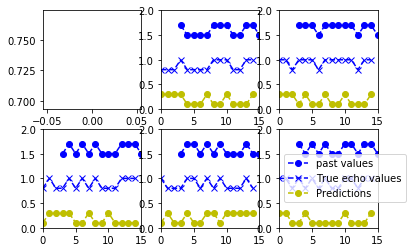

Step 100 Loss 0.39602885


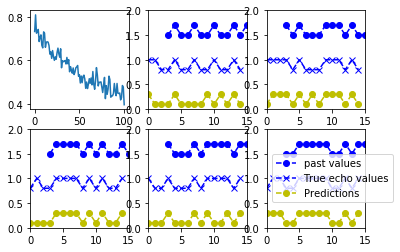

Step 200 Loss 0.36858115


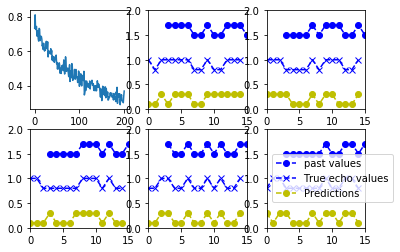

Step 300 Loss 0.26127973


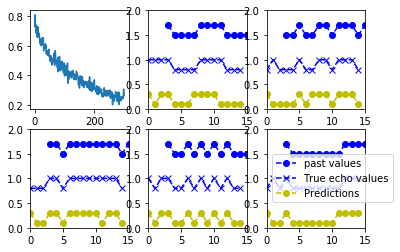

Step 400 Loss 0.22945671


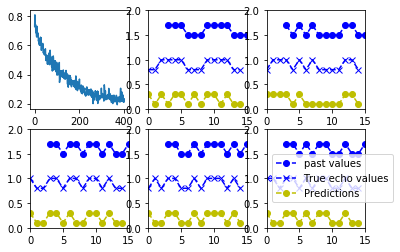

Step 500 Loss 0.20191193


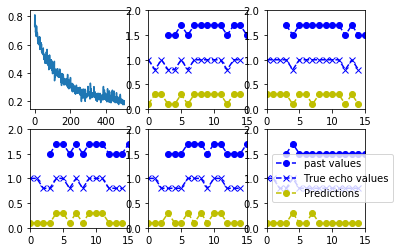

Step 600 Loss 0.17673604


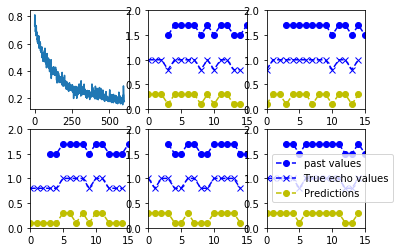

New data, epoch 1
Step 0 Loss 0.24192011


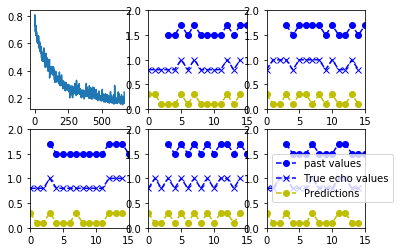

Step 100 Loss 0.24138343


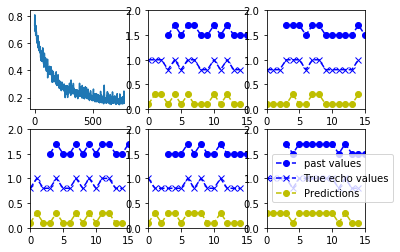

Step 200 Loss 0.15801516


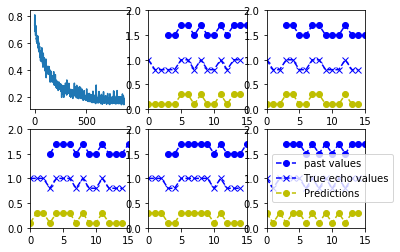

Step 300 Loss 0.15415932


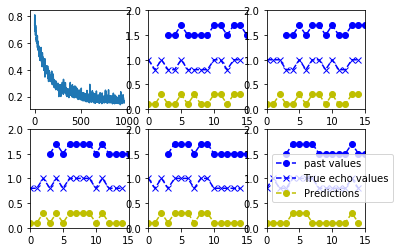

Step 400 Loss 0.18528233


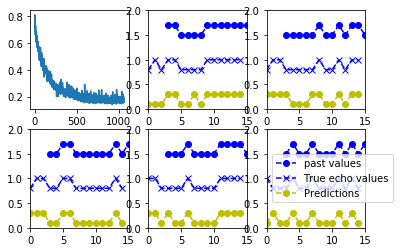

Step 500 Loss 0.18084842


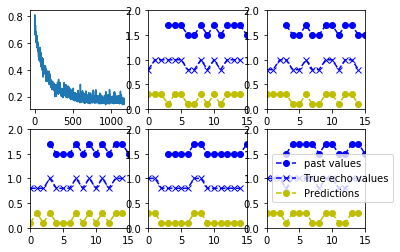

Step 600 Loss 0.15253036


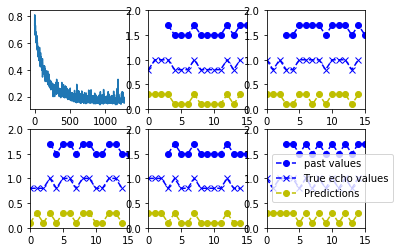

New data, epoch 2
Step 0 Loss 0.18663388


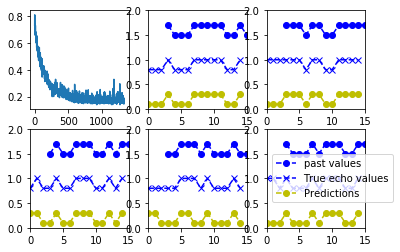

Step 100 Loss 0.1453068


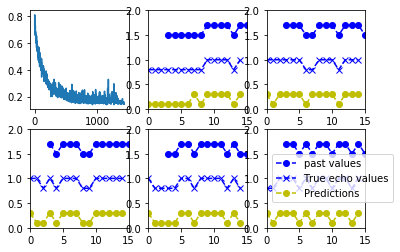

Step 200 Loss 0.1510492


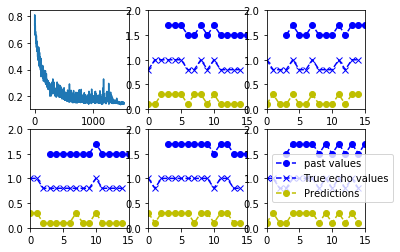

Step 300 Loss 0.1458045


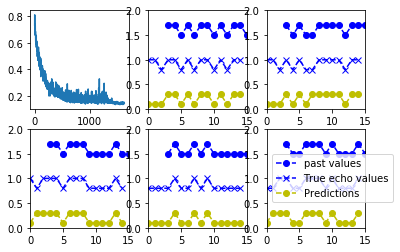

Step 400 Loss 0.1425687


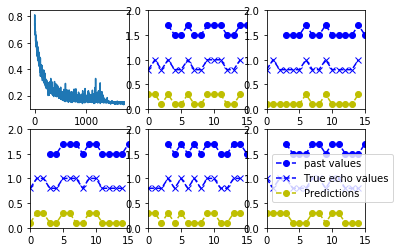

Step 500 Loss 0.14749697


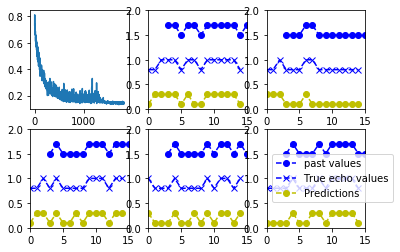

Step 600 Loss 0.14430188


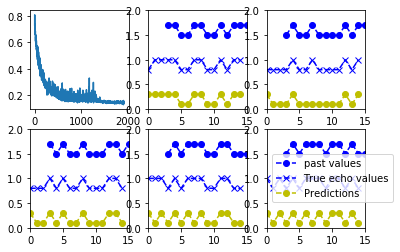

New data, epoch 3
Step 0 Loss 0.21983938


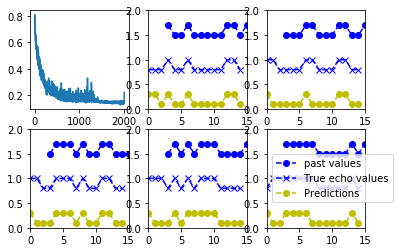

Step 100 Loss 0.14256823


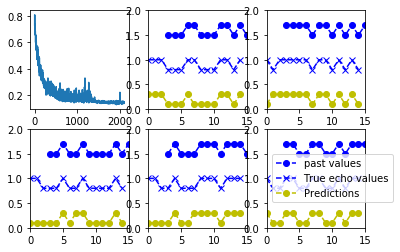

Step 200 Loss 0.15057199


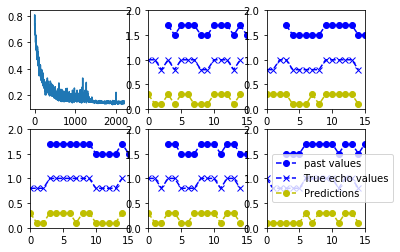

Step 300 Loss 0.13938488


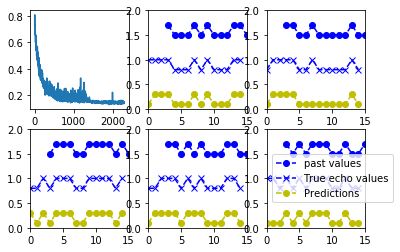

Step 400 Loss 0.1467422


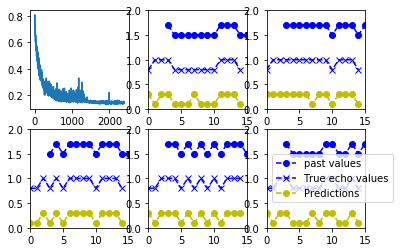

Step 500 Loss 0.15115257


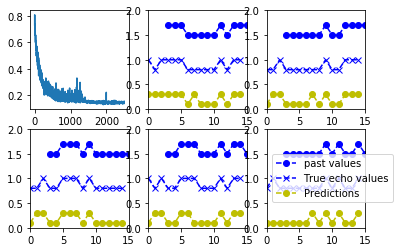

Step 600 Loss 0.14251296


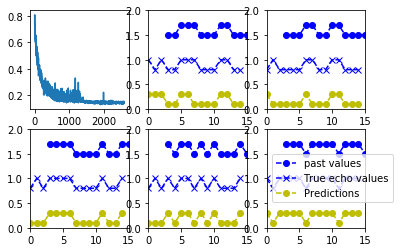

New data, epoch 4
Step 0 Loss 0.19574395


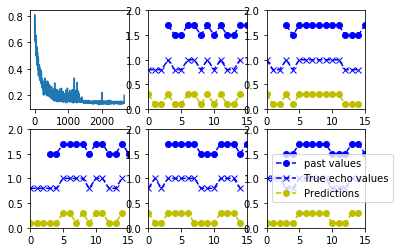

Step 100 Loss 0.14295685


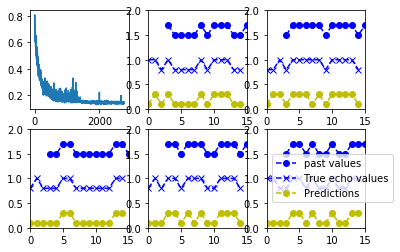

Step 200 Loss 0.13783292


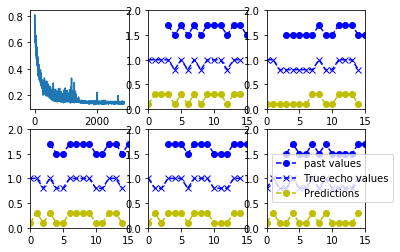

Step 300 Loss 0.13576208


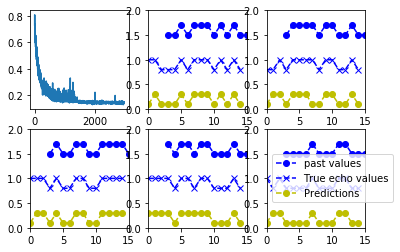

Step 400 Loss 0.14550348


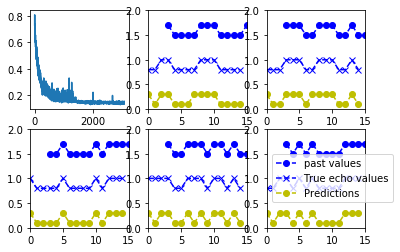

Step 500 Loss 0.14002436


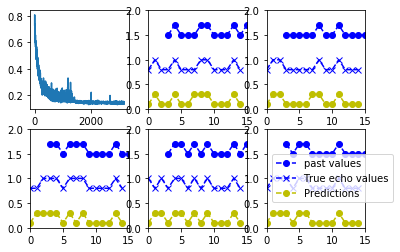

Step 600 Loss 0.1346251


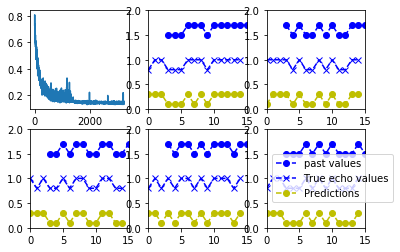

In [2]:
# -*- coding: utf-8 -*-

# 1. 定义参数生成样本数据
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

num_epochs = 5
total_series_length = 50000
truncated_backprop_length = 15
state_size = 4
num_classes = 2
echo_step = 3
batch_size = 5
num_batches = total_series_length//batch_size//truncated_backprop_length


def generateData():
    x = np.array(np.random.choice(2, total_series_length, p=[0.5, 0.5]))#在0 和1 中选择total_series_length个数
    y = np.roll(x, echo_step)#向右循环移位【1111000】---【0001111】
    y[0:echo_step] = 0

    x = x.reshape((batch_size, -1))  # 5,10000
    y = y.reshape((batch_size, -1))

    return (x, y)

# 2. 定义占位符处理输入数据
batchX_placeholder = tf.placeholder(tf.float32, [batch_size, truncated_backprop_length])
batchY_placeholder = tf.placeholder(tf.int32, [batch_size, truncated_backprop_length])
init_state = tf.placeholder(tf.float32, [batch_size, state_size])

# Unpack columns
inputs_series = tf.unstack(batchX_placeholder, axis=1)#truncated_backprop_length个序列
labels_series = tf.unstack(batchY_placeholder, axis=1)


# 3. 定义网络结构
current_state = init_state
predictions_series = []
losses =[]
for current_input, labels in zip(inputs_series,labels_series):
#for current_input in inputs_series:
    current_input = tf.reshape(current_input, [batch_size, 1])
    input_and_state_concatenated = tf.concat([current_input, current_state],1)  # current_state 4  +1

    next_state = tf.contrib.layers.fully_connected(input_and_state_concatenated,state_size
                                                    ,activation_fn=tf.tanh)
    current_state = next_state
    logits =tf.contrib.layers.fully_connected(next_state,num_classes,activation_fn=None)
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels,logits=logits)
    losses.append(loss)
    predictions = tf.nn.softmax(logits)
    predictions_series.append(predictions)
    

total_loss = tf.reduce_mean(losses)
train_step = tf.train.AdagradOptimizer(0.3).minimize(total_loss)

# plot 函数
def plot(loss_list, predictions_series, batchX, batchY):
    plt.subplot(2, 3, 1)
    plt.cla()
    plt.plot(loss_list)

    for batch_series_idx in range(batch_size):
        one_hot_output_series = np.array(predictions_series)[:, batch_series_idx, :]
        single_output_series = np.array([(1 if out[0] < 0.5 else 0) for out in one_hot_output_series])

        plt.subplot(2, 3, batch_series_idx + 2)
        plt.cla()
        plt.axis([0, truncated_backprop_length, 0, 2])
        left_offset = range(truncated_backprop_length)
        left_offset2 = range(echo_step,truncated_backprop_length+echo_step)
        
        label1 = "past values"
        label2 = "True echo values" 
        label3 = "Predictions"      
        plt.plot(left_offset2, batchX[batch_series_idx, :]*0.2+1.5, "o--b", label=label1)
        plt.plot(left_offset, batchY[batch_series_idx, :]*0.2+0.8,"x--b", label=label2)
        plt.plot(left_offset,  single_output_series*0.2+0.1 , "o--y", label=label3)
    
    plt.legend(loc='best')
    plt.draw()
    plt.pause(0.0001)


# 4. 建立session训练数据
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    plt.ion()
    plt.figure()
    plt.show()
    loss_list = []

    for epoch_idx in range(num_epochs):
        x,y = generateData()
        _current_state = np.zeros((batch_size, state_size))

        print("New data, epoch", epoch_idx)

        for batch_idx in range(num_batches):#50000/ 5 /15=分成多少段
            start_idx = batch_idx * truncated_backprop_length
            end_idx = start_idx + truncated_backprop_length

            batchX = x[:,start_idx:end_idx]
            batchY = y[:,start_idx:end_idx]

            _total_loss, _train_step, _current_state, _predictions_series = sess.run(
                [total_loss, train_step, current_state, predictions_series],
                feed_dict={
                    batchX_placeholder:batchX,
                    batchY_placeholder:batchY,
                    init_state:_current_state
                })
            loss_list.append(_total_loss)

# 5. 测试模型及可视化
            if batch_idx%100 == 0:
                print("Step",batch_idx, "Loss", _total_loss)
                plot(loss_list, _predictions_series, batchX, batchY)

plt.ioff()
plt.show()    

## 实例57：构造LSTM对MNIST分类(BasicCell & LSTMCell)

In [3]:
# -*- coding: utf-8 -*-
import tensorflow as tf
# 导入 MINST 数据集
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/data/", one_hot=True)

n_input = 28 # MNIST data 输入 (img shape: 28*28)
n_steps = 28 # timesteps
n_hidden = 128 # hidden layer num of features
n_classes = 10  # MNIST 列别 (0-9 ，一共10类)

tf.reset_default_graph()

# tf Graph input
x = tf.placeholder("float", [None, n_steps, n_input])
y = tf.placeholder("float", [None, n_classes])


x1 = tf.unstack(x, n_steps, 1)

#1 BasicLSTMCell
lstm_cell = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0)
outputs, states = tf.contrib.rnn.static_rnn(lstm_cell, x1, dtype=tf.float32)

#2 LSTMCell
#lstm_cell = tf.contrib.rnn.LSTMCell(n_hidden, forget_bias=1.0)
#outputs, states = tf.contrib.rnn.static_rnn(lstm_cell, x1, dtype=tf.float32)

#3 gru
#gru = tf.contrib.rnn.GRUCell(n_hidden)
#outputs = tf.contrib.rnn.static_rnn(gru, x1, dtype=tf.float32)

#4 创建动态RNN
#outputs,_  = tf.nn.dynamic_rnn(gru,x,dtype=tf.float32)
#outputs = tf.transpose(outputs, [1, 0, 2])

pred = tf.contrib.layers.fully_connected(outputs[-1],n_classes,activation_fn = None)



learning_rate = 0.001
training_iters = 100000
batch_size = 128
display_step = 10

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# 启动session
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    step = 1
    # Keep training until reach max iterations
    while step * batch_size < training_iters:
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        # Reshape data to get 28 seq of 28 elements
        batch_x = batch_x.reshape((batch_size, n_steps, n_input))
        # Run optimization op (backprop)
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})
        if step % display_step == 0:
            # 计算批次数据的准确率
            acc = sess.run(accuracy, feed_dict={x: batch_x, y: batch_y})
            # Calculate batch loss
            loss = sess.run(cost, feed_dict={x: batch_x, y: batch_y})
            print ("Iter " + str(step*batch_size) + ", Minibatch Loss= " + \
                  "{:.6f}".format(loss) + ", Training Accuracy= " + \
                  "{:.5f}".format(acc))
        step += 1
    print (" Finished!")

    # 计算准确率 for 128 mnist test images
    test_len = 128
    test_data = mnist.test.images[:test_len].reshape((-1, n_steps, n_input))
    test_label = mnist.test.labels[:test_len]
    print ("Testing Accuracy:", \
        sess.run(accuracy, feed_dict={x: test_data, y: test_label}))

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting /data/t10k-images-idx3-ubyte.gz
Extracting /data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API
Instructions for updating:

Future major versions of TensorFlow will allow gradient

In [4]:
# -*- coding: utf-8 -*-
import tensorflow as tf
# 导入 MINST 数据集
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/data/", one_hot=True)

n_input = 28 # MNIST data 输入 (img shape: 28*28)
n_steps = 28 # timesteps
n_hidden = 128 # hidden layer num of features
n_classes = 10  # MNIST 列别 (0-9 ，一共10类)

tf.reset_default_graph()

# tf Graph input
x = tf.placeholder("float", [None, n_steps, n_input])
y = tf.placeholder("float", [None, n_classes])


x1 = tf.unstack(x, n_steps, 1)

#1 BasicLSTMCell
#lstm_cell = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0)
#outputs, states = tf.contrib.rnn.static_rnn(lstm_cell, x1, dtype=tf.float32)

#2 LSTMCell
lstm_cell = tf.contrib.rnn.LSTMCell(n_hidden, forget_bias=1.0)
outputs, states = tf.contrib.rnn.static_rnn(lstm_cell, x1, dtype=tf.float32)

#3 gru
#gru = tf.contrib.rnn.GRUCell(n_hidden)
#outputs = tf.contrib.rnn.static_rnn(gru, x1, dtype=tf.float32)

#4 创建动态RNN
#outputs,_  = tf.nn.dynamic_rnn(gru,x,dtype=tf.float32)
#outputs = tf.transpose(outputs, [1, 0, 2])

pred = tf.contrib.layers.fully_connected(outputs[-1],n_classes,activation_fn = None)



learning_rate = 0.001
training_iters = 100000
batch_size = 128
display_step = 10

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# 启动session
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    step = 1
    # Keep training until reach max iterations
    while step * batch_size < training_iters:
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        # Reshape data to get 28 seq of 28 elements
        batch_x = batch_x.reshape((batch_size, n_steps, n_input))
        # Run optimization op (backprop)
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})
        if step % display_step == 0:
            # 计算批次数据的准确率
            acc = sess.run(accuracy, feed_dict={x: batch_x, y: batch_y})
            # Calculate batch loss
            loss = sess.run(cost, feed_dict={x: batch_x, y: batch_y})
            print ("Iter " + str(step*batch_size) + ", Minibatch Loss= " + \
                  "{:.6f}".format(loss) + ", Training Accuracy= " + \
                  "{:.5f}".format(acc))
        step += 1
    print (" Finished!")

    # 计算准确率 for 128 mnist test images
    test_len = 128
    test_data = mnist.test.images[:test_len].reshape((-1, n_steps, n_input))
    test_label = mnist.test.labels[:test_len]
    print ("Testing Accuracy:", \
        sess.run(accuracy, feed_dict={x: test_data, y: test_label}))

Extracting /data/train-images-idx3-ubyte.gz
Extracting /data/train-labels-idx1-ubyte.gz
Extracting /data/t10k-images-idx3-ubyte.gz
Extracting /data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Iter 1280, Minibatch Loss= 2.132512, Training Accuracy= 0.30469
Iter 2560, Minibatch Loss= 2.001817, Training Accuracy= 0.28125
Iter 3840, Minibatch Loss= 1.523742, Training Accuracy= 0.51562
Iter 5120, Minibatch Loss= 1.272301, Training Accuracy= 0.64844
Iter 6400, Minibatch Loss= 1.060405, Training Accuracy= 0.65625
Iter 7680, Minibatch Loss= 0.889486, Training Accuracy= 0.69531
Iter 8960, Minibatch Loss= 0.854698, Training Accuracy= 0.69531
Iter 10240, Minibatch Loss= 0.786288, Training Accuracy= 0.77344
Iter 11520, Minibatch Loss= 0.758092, Training Accuracy= 0.77344
Iter 12800, Minibatch Loss= 0.784820, Training Accuracy= 0.77344
Iter 14080, Minibatch Loss= 0.383889, Training Accurac

## 实例58：构造单层GRU网络对MNIST数据集分类

In [5]:
# -*- coding: utf-8 -*-
import tensorflow as tf
# 导入 MINST 数据集
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/data/", one_hot=True)

n_input = 28 # MNIST data 输入 (img shape: 28*28)
n_steps = 28 # timesteps
n_hidden = 128 # hidden layer num of features
n_classes = 10  # MNIST 列别 (0-9 ，一共10类)

tf.reset_default_graph()

# tf Graph input
x = tf.placeholder("float", [None, n_steps, n_input])
y = tf.placeholder("float", [None, n_classes])


x1 = tf.unstack(x, n_steps, 1)

#1 BasicLSTMCell
#lstm_cell = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0)
#outputs, states = tf.contrib.rnn.static_rnn(lstm_cell, x1, dtype=tf.float32)

#2 LSTMCell
#lstm_cell = tf.contrib.rnn.LSTMCell(n_hidden, forget_bias=1.0)
#outputs, states = tf.contrib.rnn.static_rnn(lstm_cell, x1, dtype=tf.float32)

#3 gru
gru = tf.contrib.rnn.GRUCell(n_hidden)
outputs = tf.contrib.rnn.static_rnn(gru, x1, dtype=tf.float32)

#4 创建动态RNN
#outputs,_  = tf.nn.dynamic_rnn(gru,x,dtype=tf.float32)
#outputs = tf.transpose(outputs, [1, 0, 2])

pred = tf.contrib.layers.fully_connected(outputs[-1],n_classes,activation_fn = None)



learning_rate = 0.001
training_iters = 100000
batch_size = 128
display_step = 10

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# 启动session
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    step = 1
    # Keep training until reach max iterations
    while step * batch_size < training_iters:
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        # Reshape data to get 28 seq of 28 elements
        batch_x = batch_x.reshape((batch_size, n_steps, n_input))
        # Run optimization op (backprop)
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})
        if step % display_step == 0:
            # 计算批次数据的准确率
            acc = sess.run(accuracy, feed_dict={x: batch_x, y: batch_y})
            # Calculate batch loss
            loss = sess.run(cost, feed_dict={x: batch_x, y: batch_y})
            print ("Iter " + str(step*batch_size) + ", Minibatch Loss= " + \
                  "{:.6f}".format(loss) + ", Training Accuracy= " + \
                  "{:.5f}".format(acc))
        step += 1
    print (" Finished!")

    # 计算准确率 for 128 mnist test images
    test_len = 128
    test_data = mnist.test.images[:test_len].reshape((-1, n_steps, n_input))
    test_label = mnist.test.labels[:test_len]
    print ("Testing Accuracy:", \
        sess.run(accuracy, feed_dict={x: test_data, y: test_label}))

Extracting /data/train-images-idx3-ubyte.gz
Extracting /data/train-labels-idx1-ubyte.gz
Extracting /data/t10k-images-idx3-ubyte.gz
Extracting /data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
Iter 1280, Minibatch Loss= 2.110982, Training Accuracy= 0.35156
Iter 2560, Minibatch Loss= 1.813759, Training Accuracy= 0.36719
Iter 3840, Minibatch Loss= 1.430715, Training Accuracy= 0.57812
Iter 5120, Minibatch Loss= 1.243752, Training Accuracy= 0.53906
Iter 6400, Minibatch Loss= 1.036775, Training Accuracy= 0.66406
Iter 7680, Minibatch Loss= 0.958580, Training Accuracy= 0.65625
Iter 8960, Minibatch Loss= 0.797127, Training Accuracy= 0.75000
Iter 10240, Minibatch Loss= 0.834968, Training Accuracy= 0.71094
Iter 11520, Minibatch Loss= 0.762974, Training Accuracy= 0.72656
Iter 12800, Minibatch Loss= 0.702314, Training Accuracy= 0.78125
Iter 14080, Minibatch Loss= 0.631187, Training Accuracy

## 实例59：创建动态单层RNN对MNIST数据集分类

In [6]:
# -*- coding: utf-8 -*-
import tensorflow as tf
# 导入 MINST 数据集
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/data/", one_hot=True)

n_input = 28 # MNIST data 输入 (img shape: 28*28)
n_steps = 28 # timesteps
n_hidden = 128 # hidden layer num of features
n_classes = 10  # MNIST 列别 (0-9 ，一共10类)

tf.reset_default_graph()

# tf Graph input
x = tf.placeholder("float", [None, n_steps, n_input])
y = tf.placeholder("float", [None, n_classes])


x1 = tf.unstack(x, n_steps, 1)

#1 BasicLSTMCell
#lstm_cell = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0)
#outputs, states = tf.contrib.rnn.static_rnn(lstm_cell, x1, dtype=tf.float32)

#2 LSTMCell
#lstm_cell = tf.contrib.rnn.LSTMCell(n_hidden, forget_bias=1.0)
#outputs, states = tf.contrib.rnn.static_rnn(lstm_cell, x1, dtype=tf.float32)

#3 gru
gru = tf.contrib.rnn.GRUCell(n_hidden)
#outputs = tf.contrib.rnn.static_rnn(gru, x1, dtype=tf.float32)

#4 创建动态RNN
outputs,_  = tf.nn.dynamic_rnn(gru,x,dtype=tf.float32)
outputs = tf.transpose(outputs, [1, 0, 2])

pred = tf.contrib.layers.fully_connected(outputs[-1],n_classes,activation_fn = None)



learning_rate = 0.001
training_iters = 100000
batch_size = 128
display_step = 10

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# 启动session
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    step = 1
    # Keep training until reach max iterations
    while step * batch_size < training_iters:
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        # Reshape data to get 28 seq of 28 elements
        batch_x = batch_x.reshape((batch_size, n_steps, n_input))
        # Run optimization op (backprop)
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})
        if step % display_step == 0:
            # 计算批次数据的准确率
            acc = sess.run(accuracy, feed_dict={x: batch_x, y: batch_y})
            # Calculate batch loss
            loss = sess.run(cost, feed_dict={x: batch_x, y: batch_y})
            print ("Iter " + str(step*batch_size) + ", Minibatch Loss= " + \
                  "{:.6f}".format(loss) + ", Training Accuracy= " + \
                  "{:.5f}".format(acc))
        step += 1
    print (" Finished!")

    # 计算准确率 for 128 mnist test images
    test_len = 128
    test_data = mnist.test.images[:test_len].reshape((-1, n_steps, n_input))
    test_label = mnist.test.labels[:test_len]
    print ("Testing Accuracy:", \
        sess.run(accuracy, feed_dict={x: test_data, y: test_label}))

Extracting /data/train-images-idx3-ubyte.gz
Extracting /data/train-labels-idx1-ubyte.gz
Extracting /data/t10k-images-idx3-ubyte.gz
Extracting /data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Iter 1280, Minibatch Loss= 2.117727, Training Accuracy= 0.28906
Iter 2560, Minibatch Loss= 1.873549, Training Accuracy= 0.37500
Iter 3840, Minibatch Loss= 1.643477, Training Accuracy= 0.46875
Iter 5120, Minibatch Loss= 1.384699, Training Accuracy= 0.54688
Iter 6400, Minibatch Loss= 1.180172, Training Accuracy= 0.60938
Iter 7680, Minibatch Loss= 1.117720, Training Accuracy= 0.59375
Iter 8960, Minibatch Loss= 0.758485, Training Accuracy= 0.72656
Iter 10240, Minibatch Loss= 0.766036, Training Accuracy= 0.76562
Iter 11520, Minibatch Loss= 0.644146, Training Accuracy= 0.80469
Iter 12800, Minibatch Loss= 0.611225, Training Accuracy= 0.82812
Iter 14080, Minibatch Loss= 0.442834, Training Accuracy= 0.84375
Iter 15360, Minibatch 

## 实例60：静态多层LSTM对MNIST数据集分类

In [7]:
# -*- coding: utf-8 -*-
import numpy as np
import tensorflow as tf
# 导入 MINST 数据集
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/data/", one_hot=True)

n_input = 28 # MNIST data 输入 (img shape: 28*28)
n_steps = 28 # timesteps
n_hidden = 128 # hidden layer num of features
n_classes = 10  # MNIST 列别 (0-9 ，一共10类)
batch_size = 128


tf.reset_default_graph()
# tf Graph input
x = tf.placeholder("float", [None, n_steps, n_input])
y = tf.placeholder("float", [None, n_classes])



stacked_rnn = []
for i in range(3):
    stacked_rnn.append(tf.contrib.rnn.LSTMCell(n_hidden))
mcell = tf.contrib.rnn.MultiRNNCell(stacked_rnn)

x1 = tf.unstack(x, n_steps, 1)
outputs, states = tf.contrib.rnn.static_rnn(mcell, x1, dtype=tf.float32)
pred = tf.contrib.layers.fully_connected(outputs[-1],n_classes,activation_fn = None)





learning_rate = 0.001
# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))


training_iters = 100000

display_step = 10

# 启动session
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    step = 1
    # Keep training until reach max iterations
    while step * batch_size < training_iters:
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        # Reshape data to get 28 seq of 28 elements
        batch_x = batch_x.reshape((batch_size, n_steps, n_input))
        # Run optimization op (backprop)
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})
        if step % display_step == 0:
            # 计算批次数据的准确率
            acc = sess.run(accuracy, feed_dict={x: batch_x, y: batch_y})
            # Calculate batch loss
            loss = sess.run(cost, feed_dict={x: batch_x, y: batch_y})
            print ("Iter " + str(step*batch_size) + ", Minibatch Loss= " + \
                  "{:.6f}".format(loss) + ", Training Accuracy= " + \
                  "{:.5f}".format(acc))
        step += 1
    print (" Finished!")

    # 计算准确率 for 128 mnist test images
    test_len = 100
    test_data = mnist.test.images[:test_len].reshape((-1, n_steps, n_input))
    test_label = mnist.test.labels[:test_len]
    print ("Testing Accuracy:", \
        sess.run(accuracy, feed_dict={x: test_data, y: test_label}))

Extracting /data/train-images-idx3-ubyte.gz
Extracting /data/train-labels-idx1-ubyte.gz
Extracting /data/t10k-images-idx3-ubyte.gz
Extracting /data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Iter 1280, Minibatch Loss= 1.892138, Training Accuracy= 0.27344
Iter 2560, Minibatch Loss= 1.520981, Training Accuracy= 0.42969
Iter 3840, Minibatch Loss= 1.271327, Training Accuracy= 0.53906
Iter 5120, Minibatch Loss= 0.980068, Training Accuracy= 0.65625
Iter 6400, Minibatch Loss= 0.812825, Training Accuracy= 0.74219
Iter 7680, Minibatch Loss= 0.807655, Training Accuracy= 0.74219
Iter 8960, Minibatch Loss= 0.761637, Training Accuracy= 0.77344
Iter 10240, Minibatch Loss= 0.580690, Training Accuracy= 0.82812
Iter 11520, Minibatch Loss= 0.802299, Training Accuracy= 0.72656
Iter 12800, Minibatch Loss= 0.557632, Training Accuracy= 0.82031
Iter 14080, Minibatch Loss= 0.580068, Training 

## 实例61：静态多层RNN-LSTM连接GRU对MNIST数据集分类

In [8]:
# -*- coding: utf-8 -*-
import numpy as np
import tensorflow as tf
# 导入 MINST 数据集
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/data/", one_hot=True)

n_input = 28 # MNIST data 输入 (img shape: 28*28)
n_steps = 28 # timesteps
n_hidden = 128 # hidden layer num of features
n_classes = 10  # MNIST 列别 (0-9 ，一共10类)
batch_size = 128


tf.reset_default_graph()
# tf Graph input
x = tf.placeholder("float", [None, n_steps, n_input])
y = tf.placeholder("float", [None, n_classes])

#
#stacked_rnn = []
#for i in range(3):
#    stacked_rnn.append(tf.contrib.rnn.LSTMCell(n_hidden))
#mcell = tf.contrib.rnn.MultiRNNCell(stacked_rnn)


gru = tf.contrib.rnn.GRUCell(n_hidden*2)
lstm_cell = tf.contrib.rnn.LSTMCell(n_hidden)
mcell = tf.contrib.rnn.MultiRNNCell([lstm_cell,gru])


x1 = tf.unstack(x, n_steps, 1)
outputs, states = tf.contrib.rnn.static_rnn(mcell, x1, dtype=tf.float32)
pred = tf.contrib.layers.fully_connected(outputs[-1],n_classes,activation_fn = None)




learning_rate = 0.001
# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))


training_iters = 100000

display_step = 10

# 启动session
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    step = 1
    # Keep training until reach max iterations
    while step * batch_size < training_iters:
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        # Reshape data to get 28 seq of 28 elements
        batch_x = batch_x.reshape((batch_size, n_steps, n_input))
        # Run optimization op (backprop)
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})
        if step % display_step == 0:
            # 计算批次数据的准确率
            acc = sess.run(accuracy, feed_dict={x: batch_x, y: batch_y})
            # Calculate batch loss
            loss = sess.run(cost, feed_dict={x: batch_x, y: batch_y})
            print ("Iter " + str(step*batch_size) + ", Minibatch Loss= " + \
                  "{:.6f}".format(loss) + ", Training Accuracy= " + \
                  "{:.5f}".format(acc))
        step += 1
    print (" Finished!")

    # 计算准确率 for 128 mnist test images
    test_len = 100
    test_data = mnist.test.images[:test_len].reshape((-1, n_steps, n_input))
    test_label = mnist.test.labels[:test_len]
    print ("Testing Accuracy:", \
        sess.run(accuracy, feed_dict={x: test_data, y: test_label}))

Extracting /data/train-images-idx3-ubyte.gz
Extracting /data/train-labels-idx1-ubyte.gz
Extracting /data/t10k-images-idx3-ubyte.gz
Extracting /data/t10k-labels-idx1-ubyte.gz
Iter 1280, Minibatch Loss= 1.808671, Training Accuracy= 0.42188
Iter 2560, Minibatch Loss= 1.288418, Training Accuracy= 0.59375
Iter 3840, Minibatch Loss= 0.954410, Training Accuracy= 0.75781
Iter 5120, Minibatch Loss= 0.873409, Training Accuracy= 0.70312
Iter 6400, Minibatch Loss= 0.872713, Training Accuracy= 0.66406
Iter 7680, Minibatch Loss= 0.618704, Training Accuracy= 0.83594
Iter 8960, Minibatch Loss= 0.426509, Training Accuracy= 0.88281
Iter 10240, Minibatch Loss= 0.480236, Training Accuracy= 0.86719
Iter 11520, Minibatch Loss= 0.429108, Training Accuracy= 0.84375
Iter 12800, Minibatch Loss= 0.552932, Training Accuracy= 0.82812
Iter 14080, Minibatch Loss= 0.362248, Training Accuracy= 0.87500
Iter 15360, Minibatch Loss= 0.265852, Training Accuracy= 0.92969
Iter 16640, Minibatch Loss= 0.315052, Training Accura

## 实例62：动态多层RNN对MNIST分类

In [9]:
# -*- coding: utf-8 -*-
import numpy as np
import tensorflow as tf
# 导入 MINST 数据集
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/data/", one_hot=True)

n_input = 28 # MNIST data 输入 (img shape: 28*28)
n_steps = 28 # timesteps
n_hidden = 128 # hidden layer num of features
n_classes = 10  # MNIST 列别 (0-9 ，一共10类)
batch_size = 128


tf.reset_default_graph()
# tf Graph input
x = tf.placeholder("float", [None, n_steps, n_input])
y = tf.placeholder("float", [None, n_classes])

#
#stacked_rnn = []
#for i in range(3):
#    stacked_rnn.append(tf.contrib.rnn.LSTMCell(n_hidden))
#mcell = tf.contrib.rnn.MultiRNNCell(stacked_rnn)


gru = tf.contrib.rnn.GRUCell(n_hidden*2)
lstm_cell = tf.contrib.rnn.LSTMCell(n_hidden)
mcell = tf.contrib.rnn.MultiRNNCell([lstm_cell,gru])


#x1 = tf.unstack(x, n_steps, 1)
#outputs, states = tf.contrib.rnn.static_rnn(mcell, x1, dtype=tf.float32)
#pred = tf.contrib.layers.fully_connected(outputs[-1],n_classes,activation_fn = None)



outputs,states  = tf.nn.dynamic_rnn(mcell,x,dtype=tf.float32)#(?, 28, 256)
outputs = tf.transpose(outputs, [1, 0, 2])#(28, ?, 256) 28个时序，取最后一个时序outputs[-1]=(?,256)
pred = tf.contrib.layers.fully_connected(outputs[-1],n_classes,activation_fn = None)


learning_rate = 0.001
# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))


training_iters = 100000

display_step = 10

# 启动session
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    step = 1
    # Keep training until reach max iterations
    while step * batch_size < training_iters:
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        # Reshape data to get 28 seq of 28 elements
        batch_x = batch_x.reshape((batch_size, n_steps, n_input))
        # Run optimization op (backprop)
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})
        if step % display_step == 0:
            # 计算批次数据的准确率
            acc = sess.run(accuracy, feed_dict={x: batch_x, y: batch_y})
            # Calculate batch loss
            loss = sess.run(cost, feed_dict={x: batch_x, y: batch_y})
            print ("Iter " + str(step*batch_size) + ", Minibatch Loss= " + \
                  "{:.6f}".format(loss) + ", Training Accuracy= " + \
                  "{:.5f}".format(acc))
        step += 1
    print (" Finished!")

    # 计算准确率 for 128 mnist test images
    test_len = 100
    test_data = mnist.test.images[:test_len].reshape((-1, n_steps, n_input))
    test_label = mnist.test.labels[:test_len]
    print ("Testing Accuracy:", \
        sess.run(accuracy, feed_dict={x: test_data, y: test_label}))

Extracting /data/train-images-idx3-ubyte.gz
Extracting /data/train-labels-idx1-ubyte.gz
Extracting /data/t10k-images-idx3-ubyte.gz
Extracting /data/t10k-labels-idx1-ubyte.gz
Iter 1280, Minibatch Loss= 1.786891, Training Accuracy= 0.36719
Iter 2560, Minibatch Loss= 1.360941, Training Accuracy= 0.55469
Iter 3840, Minibatch Loss= 1.208105, Training Accuracy= 0.60156
Iter 5120, Minibatch Loss= 1.075533, Training Accuracy= 0.62500
Iter 6400, Minibatch Loss= 0.780158, Training Accuracy= 0.72656
Iter 7680, Minibatch Loss= 0.785984, Training Accuracy= 0.71875
Iter 8960, Minibatch Loss= 0.459019, Training Accuracy= 0.87500
Iter 10240, Minibatch Loss= 0.699168, Training Accuracy= 0.78125
Iter 11520, Minibatch Loss= 0.549069, Training Accuracy= 0.82031
Iter 12800, Minibatch Loss= 0.412937, Training Accuracy= 0.83594
Iter 14080, Minibatch Loss= 0.359638, Training Accuracy= 0.88281
Iter 15360, Minibatch Loss= 0.358867, Training Accuracy= 0.89844
Iter 16640, Minibatch Loss= 0.384718, Training Accura

## 实例63：构建单层动态BiRNN对MNIST数据集分类

In [1]:
# -*- coding: utf-8 -*-
import tensorflow as tf
from tensorflow.contrib import rnn
# 导入 MINST 数据集
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/data/", one_hot=True)

#参数设置
learning_rate = 0.001
training_iters = 100000
batch_size = 128
display_step = 10

# Network Parameters
n_input = 28 # MNIST data 输入 (img shape: 28*28)
n_steps = 28 # timesteps
n_hidden = 128 # hidden layer num of features
n_classes = 10  # MNIST 列别 (0-9 ，一共10类)

tf.reset_default_graph()

# tf Graph input
x = tf.placeholder("float", [None, n_steps, n_input])
y = tf.placeholder("float", [None, n_classes])



x1 = tf.unstack(x, n_steps, 1)
lstm_fw_cell = rnn.BasicLSTMCell(n_hidden, forget_bias=1.0)
# 反向cell
lstm_bw_cell = rnn.BasicLSTMCell(n_hidden, forget_bias=1.0)
outputs, output_states = tf.nn.bidirectional_dynamic_rnn(lstm_fw_cell,lstm_bw_cell,x,
                                              dtype=tf.float32)
print(len(outputs),outputs[0].shape,outputs[1].shape)
outputs = tf.concat(outputs, 2)
outputs = tf.transpose(outputs, [1, 0, 2])

pred = tf.contrib.layers.fully_connected(outputs[-1],n_classes,activation_fn = None)



# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))



# 启动session
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    step = 1
    # Keep training until reach max iterations
    while step * batch_size < training_iters:
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        # Reshape data to get 28 seq of 28 elements
        batch_x = batch_x.reshape((batch_size, n_steps, n_input))
        # Run optimization op (backprop)
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})
        if step % display_step == 0:
            # 计算批次数据的准确率
            acc = sess.run(accuracy, feed_dict={x: batch_x, y: batch_y})
            # Calculate batch loss
            loss = sess.run(cost, feed_dict={x: batch_x, y: batch_y})
            print ("Iter " + str(step*batch_size) + ", Minibatch Loss= " + \
                  "{:.6f}".format(loss) + ", Training Accuracy= " + \
                  "{:.5f}".format(acc))
        step += 1
    print (" Finished!")

    # 计算准确率 for 128 mnist test images
    test_len = 128
    test_data = mnist.test.images[:test_len].reshape((-1, n_steps, n_input))
    test_label = mnist.test.labels[:test_len]
    print ("Testing Accuracy:", \
        sess.run(accuracy, feed_dict={x: test_data, y: test_label}))



C:\Users\adward\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting /data/t10k-images-idx3-ubyte.gz
Extracting /data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell))`, which is equivalent to this API
Instructions for updating:
Please use `keras.layers.RNN(cell)`, whic

Iter 89600, Minibatch Loss= 0.123343, Training Accuracy= 0.96094
Iter 90880, Minibatch Loss= 0.217972, Training Accuracy= 0.92188
Iter 92160, Minibatch Loss= 0.082326, Training Accuracy= 0.99219
Iter 93440, Minibatch Loss= 0.206144, Training Accuracy= 0.94531
Iter 94720, Minibatch Loss= 0.119195, Training Accuracy= 0.97656
Iter 96000, Minibatch Loss= 0.076865, Training Accuracy= 0.97656
Iter 97280, Minibatch Loss= 0.208217, Training Accuracy= 0.92969
Iter 98560, Minibatch Loss= 0.143691, Training Accuracy= 0.94531
Iter 99840, Minibatch Loss= 0.119417, Training Accuracy= 0.97656
 Finished!
Testing Accuracy: 0.9765625


## 实例64：构建单层静态BiRNN对MNIST数据集分类

In [2]:
# -*- coding: utf-8 -*-
import tensorflow as tf
from tensorflow.contrib import rnn
# 导入 MINST 数据集
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/data/", one_hot=True)

#参数设置
learning_rate = 0.001
training_iters = 100000
batch_size = 128
display_step = 10

# Network Parameters
n_input = 28 # MNIST data 输入 (img shape: 28*28)
n_steps = 28 # timesteps
n_hidden = 128 # hidden layer num of features
n_classes = 10  # MNIST 列别 (0-9 ，一共10类)

tf.reset_default_graph()

# tf Graph input
x = tf.placeholder("float", [None, n_steps, n_input])
y = tf.placeholder("float", [None, n_classes])


x1 = tf.unstack(x, n_steps, 1)
lstm_fw_cell = rnn.BasicLSTMCell(n_hidden, forget_bias=1.0)
# 反向cell
lstm_bw_cell = rnn.BasicLSTMCell(n_hidden, forget_bias=1.0)
outputs, _, _ = rnn.static_bidirectional_rnn(lstm_fw_cell, lstm_bw_cell, x1,
                                              dtype=tf.float32)
print(outputs[0].shape,len(outputs))
pred = tf.contrib.layers.fully_connected(outputs[-1],n_classes,activation_fn = None)



# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))



# 启动session
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    step = 1
    # Keep training until reach max iterations
    while step * batch_size < training_iters:
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        # Reshape data to get 28 seq of 28 elements
        batch_x = batch_x.reshape((batch_size, n_steps, n_input))
        # Run optimization op (backprop)
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})
        if step % display_step == 0:
            # 计算批次数据的准确率
            acc = sess.run(accuracy, feed_dict={x: batch_x, y: batch_y})
            # Calculate batch loss
            loss = sess.run(cost, feed_dict={x: batch_x, y: batch_y})
            print ("Iter " + str(step*batch_size) + ", Minibatch Loss= " + \
                  "{:.6f}".format(loss) + ", Training Accuracy= " + \
                  "{:.5f}".format(acc))
        step += 1
    print (" Finished!")

    # 计算准确率 for 128 mnist test images
    test_len = 128
    test_data = mnist.test.images[:test_len].reshape((-1, n_steps, n_input))
    test_label = mnist.test.labels[:test_len]
    print ("Testing Accuracy:", \
        sess.run(accuracy, feed_dict={x: test_data, y: test_label}))



Extracting /data/train-images-idx3-ubyte.gz
Extracting /data/train-labels-idx1-ubyte.gz
Extracting /data/t10k-images-idx3-ubyte.gz
Extracting /data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell, unroll=True))`, which is equivalent to this API
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API
(?, 256) 28
Iter 1280, Minibatch Loss= 2.198292, Training Accuracy= 0.34375
Iter 2560, Minibatch Loss= 1.922280, Training Accuracy= 0.33594
Iter 3840, Minibatch Loss= 1.619660, Training Accuracy= 0.48438
Iter 5120, Minibatch Loss= 1.287644, Training Accuracy= 0.57812
Iter 6400, Minibatch Loss= 1.054544, Training Accuracy= 0.63281
Iter 7680, Minibatch Loss= 0.970391, Training Accuracy= 0.64844
Iter 8960, Minibatch Loss= 0.785846, Training Accuracy= 0.75000
Iter 10240, Minibatch Loss= 0.735042, Training Accuracy= 0.77344
Iter 11520, Minibatch Loss= 0.709633, Training Accuracy

## 实例65：构建多层BiRNN对MNIST数据集分类

In [3]:
# -*- coding: utf-8 -*-
import tensorflow as tf
from tensorflow.contrib import rnn
# 导入 MINST 数据集
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/data/", one_hot=True)

#参数设置
learning_rate = 0.001
training_iters = 100000
batch_size = 128
display_step = 10

# Network Parameters
n_input = 28 # MNIST data 输入 (img shape: 28*28)
n_steps = 28 # timesteps
n_hidden = 128 # hidden layer num of features
n_classes = 10  # MNIST 列别 (0-9 ，一共10类)

tf.reset_default_graph()

# tf Graph input
x = tf.placeholder("float", [None, n_steps, n_input])
y = tf.placeholder("float", [None, n_classes])


x1 = tf.unstack(x, n_steps, 1)
lstm_fw_cell = rnn.BasicLSTMCell(n_hidden, forget_bias=1.0)
lstm_bw_cell = rnn.BasicLSTMCell(n_hidden, forget_bias=1.0)



#outputs, _, _ = rnn.static_bidirectional_rnn(lstm_fw_cell, lstm_bw_cell, x1,
#                                              dtype=tf.float32)

outputs, _, _ = rnn.stack_bidirectional_rnn([lstm_fw_cell],[lstm_bw_cell], x1,
                                              dtype=tf.float32)

                                            

print(outputs[0].shape,len(outputs))
pred = tf.contrib.layers.fully_connected(outputs[-1],n_classes,activation_fn = None)


# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))



# 启动session
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    step = 1
    # Keep training until reach max iterations
    while step * batch_size < training_iters:
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        # Reshape data to get 28 seq of 28 elements
        batch_x = batch_x.reshape((batch_size, n_steps, n_input))
        # Run optimization op (backprop)
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})
        if step % display_step == 0:
            # 计算批次数据的准确率
            acc = sess.run(accuracy, feed_dict={x: batch_x, y: batch_y})
            # Calculate batch loss
            loss = sess.run(cost, feed_dict={x: batch_x, y: batch_y})
            print ("Iter " + str(step*batch_size) + ", Minibatch Loss= " + \
                  "{:.6f}".format(loss) + ", Training Accuracy= " + \
                  "{:.5f}".format(acc))
        step += 1
    print (" Finished!")

    # 计算准确率 for 128 mnist test images
    test_len = 128
    test_data = mnist.test.images[:test_len].reshape((-1, n_steps, n_input))
    test_label = mnist.test.labels[:test_len]
    print ("Testing Accuracy:", \
        sess.run(accuracy, feed_dict={x: test_data, y: test_label}))



Extracting /data/train-images-idx3-ubyte.gz
Extracting /data/train-labels-idx1-ubyte.gz
Extracting /data/t10k-images-idx3-ubyte.gz
Extracting /data/t10k-labels-idx1-ubyte.gz
(?, 256) 28
Iter 1280, Minibatch Loss= 2.172426, Training Accuracy= 0.36719
Iter 2560, Minibatch Loss= 1.861094, Training Accuracy= 0.30469
Iter 3840, Minibatch Loss= 1.509905, Training Accuracy= 0.53125
Iter 5120, Minibatch Loss= 1.420893, Training Accuracy= 0.52344
Iter 6400, Minibatch Loss= 1.035572, Training Accuracy= 0.65625
Iter 7680, Minibatch Loss= 0.857329, Training Accuracy= 0.69531
Iter 8960, Minibatch Loss= 0.792173, Training Accuracy= 0.75000
Iter 10240, Minibatch Loss= 0.736671, Training Accuracy= 0.77344
Iter 11520, Minibatch Loss= 0.735905, Training Accuracy= 0.77344
Iter 12800, Minibatch Loss= 0.661815, Training Accuracy= 0.80469
Iter 14080, Minibatch Loss= 0.606804, Training Accuracy= 0.77344
Iter 15360, Minibatch Loss= 0.560650, Training Accuracy= 0.81250
Iter 16640, Minibatch Loss= 0.492422, Tra

## list多层BiRNN

In [4]:
# -*- coding: utf-8 -*-
import tensorflow as tf
from tensorflow.contrib import rnn
# 导入 MINST 数据集
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/data/", one_hot=True)

#参数设置
learning_rate = 0.001
training_iters = 100000
batch_size = 128
display_step = 10

# Network Parameters
n_input = 28 # MNIST data 输入 (img shape: 28*28)
n_steps = 28 # timesteps
n_hidden = 128 # hidden layer num of features
n_classes = 10  # MNIST 列别 (0-9 ，一共10类)

tf.reset_default_graph()

# tf Graph input
x = tf.placeholder("float", [None, n_steps, n_input])
y = tf.placeholder("float", [None, n_classes])


x1 = tf.unstack(x, n_steps, 1)
lstm_fw_cell = rnn.BasicLSTMCell(n_hidden, forget_bias=1.0)
lstm_bw_cell = rnn.BasicLSTMCell(n_hidden, forget_bias=1.0)



#outputs, _, _ = rnn.static_bidirectional_rnn(lstm_fw_cell, lstm_bw_cell, x1,
#                                              dtype=tf.float32)

#outputs, _, _ = rnn.stack_bidirectional_rnn([lstm_fw_cell],[lstm_bw_cell], x1,
#                                              dtype=tf.float32)


stacked_rnn = []
stacked_bw_rnn = []
for i in range(3):
    stacked_rnn.append(tf.contrib.rnn.LSTMCell(n_hidden))
    stacked_bw_rnn.append(tf.contrib.rnn.LSTMCell(n_hidden))
    
outputs, _, _ = rnn.stack_bidirectional_rnn(stacked_rnn,stacked_bw_rnn, x1,
                                              dtype=tf.float32)    


pred = tf.contrib.layers.fully_connected(outputs[-1],n_classes,activation_fn = None)


# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))



# 启动session
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    step = 1
    # Keep training until reach max iterations
    while step * batch_size < training_iters:
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        # Reshape data to get 28 seq of 28 elements
        batch_x = batch_x.reshape((batch_size, n_steps, n_input))
        # Run optimization op (backprop)
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})
        if step % display_step == 0:
            # 计算批次数据的准确率
            acc = sess.run(accuracy, feed_dict={x: batch_x, y: batch_y})
            # Calculate batch loss
            loss = sess.run(cost, feed_dict={x: batch_x, y: batch_y})
            print ("Iter " + str(step*batch_size) + ", Minibatch Loss= " + \
                  "{:.6f}".format(loss) + ", Training Accuracy= " + \
                  "{:.5f}".format(acc))
        step += 1
    print (" Finished!")

    # 计算准确率 for 128 mnist test images
    test_len = 128
    test_data = mnist.test.images[:test_len].reshape((-1, n_steps, n_input))
    test_label = mnist.test.labels[:test_len]
    print ("Testing Accuracy:", \
        sess.run(accuracy, feed_dict={x: test_data, y: test_label}))



Extracting /data/train-images-idx3-ubyte.gz
Extracting /data/train-labels-idx1-ubyte.gz
Extracting /data/t10k-images-idx3-ubyte.gz
Extracting /data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Iter 1280, Minibatch Loss= 1.821590, Training Accuracy= 0.35156
Iter 2560, Minibatch Loss= 1.534426, Training Accuracy= 0.45312
Iter 3840, Minibatch Loss= 1.064070, Training Accuracy= 0.64062
Iter 5120, Minibatch Loss= 0.864886, Training Accuracy= 0.69531
Iter 6400, Minibatch Loss= 0.761668, Training Accuracy= 0.71094
Iter 7680, Minibatch Loss= 0.740874, Training Accuracy= 0.77344
Iter 8960, Minibatch Loss= 0.588481, Training Accuracy= 0.81250
Iter 10240, Minibatch Loss= 0.462982, Training Accuracy= 0.82812
Iter 11520, Minibatch Loss= 0.370633, Training Accuracy= 0.88281
Iter 12800, Minibatch Loss= 0.338352, Training Accuracy= 0.89062
Iter 14080, Minibatch Loss= 0.331004, Training Accurac

## MultiBiRNN

In [5]:
# -*- coding: utf-8 -*-
import tensorflow as tf
from tensorflow.contrib import rnn
# 导入 MINST 数据集
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/data/", one_hot=True)

#参数设置
learning_rate = 0.001
training_iters = 100000
batch_size = 128
display_step = 10

# Network Parameters
n_input = 28 # MNIST data 输入 (img shape: 28*28)
n_steps = 28 # timesteps
n_hidden = 128 # hidden layer num of features
n_classes = 10  # MNIST 列别 (0-9 ，一共10类)

tf.reset_default_graph()

# tf Graph input
x = tf.placeholder("float", [None, n_steps, n_input])
y = tf.placeholder("float", [None, n_classes])


x1 = tf.unstack(x, n_steps, 1)
lstm_fw_cell = rnn.BasicLSTMCell(n_hidden, forget_bias=1.0)
lstm_bw_cell = rnn.BasicLSTMCell(n_hidden, forget_bias=1.0)



#outputs, _, _ = rnn.static_bidirectional_rnn(lstm_fw_cell, lstm_bw_cell, x1,
#                                              dtype=tf.float32)

#outputs, _, _ = rnn.stack_bidirectional_rnn([lstm_fw_cell],[lstm_bw_cell], x1,
#                                              dtype=tf.float32)


stacked_rnn = []
stacked_bw_rnn = []
for i in range(3):
    stacked_rnn.append(tf.contrib.rnn.LSTMCell(n_hidden))
    stacked_bw_rnn.append(tf.contrib.rnn.LSTMCell(n_hidden))
    
#outputs, _, _ = rnn.stack_bidirectional_rnn(stacked_rnn,stacked_bw_rnn, x1,
#                                              dtype=tf.float32)    

mcell = tf.contrib.rnn.MultiRNNCell(stacked_rnn)
mcell_bw = tf.contrib.rnn.MultiRNNCell(stacked_bw_rnn)

outputs, _, _ = rnn.stack_bidirectional_rnn([mcell],[mcell_bw], x1,
                                              dtype=tf.float32)


#outputs, _, _ = rnn.stack_bidirectional_dynamic_rnn([mcell],[mcell_bw], x,
#                                              dtype=tf.float32)
#outputs = tf.transpose(outputs, [1, 0, 2])                                              
#print(outputs[0].shape,outputs.shape)
pred = tf.contrib.layers.fully_connected(outputs[-1],n_classes,activation_fn = None)


# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))



# 启动session
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    step = 1
    # Keep training until reach max iterations
    while step * batch_size < training_iters:
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        # Reshape data to get 28 seq of 28 elements
        batch_x = batch_x.reshape((batch_size, n_steps, n_input))
        # Run optimization op (backprop)
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})
        if step % display_step == 0:
            # 计算批次数据的准确率
            acc = sess.run(accuracy, feed_dict={x: batch_x, y: batch_y})
            # Calculate batch loss
            loss = sess.run(cost, feed_dict={x: batch_x, y: batch_y})
            print ("Iter " + str(step*batch_size) + ", Minibatch Loss= " + \
                  "{:.6f}".format(loss) + ", Training Accuracy= " + \
                  "{:.5f}".format(acc))
        step += 1
    print (" Finished!")

    # 计算准确率 for 128 mnist test images
    test_len = 128
    test_data = mnist.test.images[:test_len].reshape((-1, n_steps, n_input))
    test_label = mnist.test.labels[:test_len]
    print ("Testing Accuracy:", \
        sess.run(accuracy, feed_dict={x: test_data, y: test_label}))



Extracting /data/train-images-idx3-ubyte.gz
Extracting /data/train-labels-idx1-ubyte.gz
Extracting /data/t10k-images-idx3-ubyte.gz
Extracting /data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Iter 1280, Minibatch Loss= 1.969089, Training Accuracy= 0.28906
Iter 2560, Minibatch Loss= 1.607973, Training Accuracy= 0.40625
Iter 3840, Minibatch Loss= 1.223222, Training Accuracy= 0.59375
Iter 5120, Minibatch Loss= 1.054859, Training Accuracy= 0.64844
Iter 6400, Minibatch Loss= 0.956632, Training Accuracy= 0.71875
Iter 7680, Minibatch Loss= 0.862249, Training Accuracy= 0.70312
Iter 8960, Minibatch Loss= 0.752958, Training Accuracy= 0.77344
Iter 10240, Minibatch Loss= 0.697205, Training Accuracy= 0.77344
Iter 11520, Minibatch Loss= 0.563148, Training Accuracy= 0.79688
Iter 12800, Minibatch Loss= 0.559524, Training Accuracy= 0.82031
Iter 14080, Minibatch Loss= 0.394891, Training 

## 实例66：构建多层动态BiRNN对MNIST数据集分类

In [6]:
# -*- coding: utf-8 -*-
import tensorflow as tf
from tensorflow.contrib import rnn
# 导入 MINST 数据集
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/data/", one_hot=True)

#参数设置
learning_rate = 0.001
training_iters = 100000
batch_size = 128
display_step = 10

# Network Parameters
n_input = 28 # MNIST data 输入 (img shape: 28*28)
n_steps = 28 # timesteps
n_hidden = 128 # hidden layer num of features
n_classes = 10  # MNIST 列别 (0-9 ，一共10类)

tf.reset_default_graph()

# tf Graph input
x = tf.placeholder("float", [None, n_steps, n_input])
y = tf.placeholder("float", [None, n_classes])


x1 = tf.unstack(x, n_steps, 1)
lstm_fw_cell = rnn.BasicLSTMCell(n_hidden, forget_bias=1.0)
lstm_bw_cell = rnn.BasicLSTMCell(n_hidden, forget_bias=1.0)



#outputs, _, _ = rnn.static_bidirectional_rnn(lstm_fw_cell, lstm_bw_cell, x1,
#                                              dtype=tf.float32)

#outputs, _, _ = rnn.stack_bidirectional_rnn([lstm_fw_cell],[lstm_bw_cell], x1,
#                                              dtype=tf.float32)


stacked_rnn = []
stacked_bw_rnn = []
for i in range(3):
    stacked_rnn.append(tf.contrib.rnn.LSTMCell(n_hidden))
    stacked_bw_rnn.append(tf.contrib.rnn.LSTMCell(n_hidden))
    
#outputs, _, _ = rnn.stack_bidirectional_rnn(stacked_rnn,stacked_bw_rnn, x1,
#                                              dtype=tf.float32)    

mcell = tf.contrib.rnn.MultiRNNCell(stacked_rnn)
mcell_bw = tf.contrib.rnn.MultiRNNCell(stacked_bw_rnn)

#outputs, _, _ = rnn.stack_bidirectional_rnn([mcell],[mcell_bw], x1,
#                                              dtype=tf.float32)


outputs, _, _ = rnn.stack_bidirectional_dynamic_rnn([mcell],[mcell_bw], x,
                                              dtype=tf.float32)
outputs = tf.transpose(outputs, [1, 0, 2]) #batch_size, max_time, layers_output]`                                             
print(outputs[0].shape,outputs.shape)
pred = tf.contrib.layers.fully_connected(outputs[-1],n_classes,activation_fn = None)


# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))



# 启动session
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    step = 1
    # Keep training until reach max iterations
    while step * batch_size < training_iters:
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        # Reshape data to get 28 seq of 28 elements
        batch_x = batch_x.reshape((batch_size, n_steps, n_input))
        # Run optimization op (backprop)
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})
        if step % display_step == 0:
            # 计算批次数据的准确率
            acc = sess.run(accuracy, feed_dict={x: batch_x, y: batch_y})
            # Calculate batch loss
            loss = sess.run(cost, feed_dict={x: batch_x, y: batch_y})
            print ("Iter " + str(step*batch_size) + ", Minibatch Loss= " + \
                  "{:.6f}".format(loss) + ", Training Accuracy= " + \
                  "{:.5f}".format(acc))
        step += 1
    print (" Finished!")

    # 计算准确率 for 128 mnist test images
    test_len = 128
    test_data = mnist.test.images[:test_len].reshape((-1, n_steps, n_input))
    test_label = mnist.test.labels[:test_len]
    print ("Testing Accuracy:", \
        sess.run(accuracy, feed_dict={x: test_data, y: test_label}))



Extracting /data/train-images-idx3-ubyte.gz
Extracting /data/train-labels-idx1-ubyte.gz
Extracting /data/t10k-images-idx3-ubyte.gz
Extracting /data/t10k-labels-idx1-ubyte.gz
(?, 256) (28, ?, 256)
Iter 1280, Minibatch Loss= 1.925515, Training Accuracy= 0.28906
Iter 2560, Minibatch Loss= 1.478539, Training Accuracy= 0.47656
Iter 3840, Minibatch Loss= 1.367934, Training Accuracy= 0.59375
Iter 5120, Minibatch Loss= 1.002120, Training Accuracy= 0.67188
Iter 6400, Minibatch Loss= 0.918952, Training Accuracy= 0.64062
Iter 7680, Minibatch Loss= 0.822888, Training Accuracy= 0.70312
Iter 8960, Minibatch Loss= 0.806084, Training Accuracy= 0.72656
Iter 10240, Minibatch Loss= 0.769249, Training Accuracy= 0.75781
Iter 11520, Minibatch Loss= 0.657592, Training Accuracy= 0.75781
Iter 12800, Minibatch Loss= 0.659502, Training Accuracy= 0.78125
Iter 14080, Minibatch Loss= 0.473548, Training Accuracy= 0.83594
Iter 15360, Minibatch Loss= 0.301996, Training Accuracy= 0.92188
Iter 16640, Minibatch Loss= 0.4

## 实例67：在GRUCell中实现LN

In [19]:
# -*- coding: utf-8 -*-
import numpy as np
import tensorflow as tf
# 导入 MINST 数据集
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/data/", one_hot=True)

from tensorflow.python.ops.rnn_cell_impl import  RNNCell
from tensorflow.python.ops.rnn_cell_impl import  LayerRNNCell
from tensorflow.python.ops.math_ops import sigmoid
from tensorflow.python.ops.math_ops import tanh
from tensorflow.python.ops import variable_scope as vs
from tensorflow.python.ops import array_ops
from tensorflow.contrib.rnn.python.ops.core_rnn_cell import _linear 
from tensorflow.python.layers import base as base_layer
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import init_ops
from tensorflow.python.ops import nn_ops

print(tf.__version__)

tf.reset_default_graph()

def ln(tensor, scope = None, epsilon = 1e-5):
    """ Layer normalizes a 2D tensor along its second axis """
    assert(len(tensor.get_shape()) == 2)
    m, v = tf.nn.moments(tensor, [1], keep_dims=True)
    if not isinstance(scope, str):
        scope = ''
    with tf.variable_scope(scope + 'layer_norm'):
        scale = tf.get_variable('scale',
                                shape=[tensor.get_shape()[1]],
                                initializer=tf.constant_initializer(1))
        shift = tf.get_variable('shift',
                                shape=[tensor.get_shape()[1]],
                                initializer=tf.constant_initializer(0))
    LN_initial = (tensor - m) / tf.sqrt(v + epsilon)

    return LN_initial * scale + shift

_BIAS_VARIABLE_NAME = "bias"
_WEIGHTS_VARIABLE_NAME = "kernel"


class LNGRUCell(LayerRNNCell):
  """Gated Recurrent Unit cell (cf. http://arxiv.org/abs/1406.1078).

  Args:
    num_units: int, The number of units in the GRU cell.
    activation: Nonlinearity to use.  Default: `tanh`.
    reuse: (optional) Python boolean describing whether to reuse variables
     in an existing scope.  If not `True`, and the existing scope already has
     the given variables, an error is raised.
    kernel_initializer: (optional) The initializer to use for the weight and
    projection matrices.
    bias_initializer: (optional) The initializer to use for the bias.
    name: String, the name of the layer. Layers with the same name will
      share weights, but to avoid mistakes we require reuse=True in such
      cases.
  """

  def __init__(self,
               num_units,
               activation=None,
               reuse=None,
               kernel_initializer=None,
               bias_initializer=None,
               name=None):
    #super(GRUCell, self).__init__(_reuse=reuse, name=name)#原来
    super(LNGRUCell, self).__init__(_reuse=reuse, name=name)

    # Inputs must be 2-dimensional.
    self.input_spec = base_layer.InputSpec(ndim=2)

    self._num_units = num_units
    self._activation = activation or math_ops.tanh
    self._kernel_initializer = kernel_initializer
    self._bias_initializer = bias_initializer

  @property
  def state_size(self):
    return self._num_units

  @property
  def output_size(self):
    return self._num_units

  def build(self, inputs_shape):
    if inputs_shape[1].value is None:
      raise ValueError("Expected inputs.shape[-1] to be known, saw shape: %s"
                       % inputs_shape)

    input_depth = inputs_shape[1].value
    self._gate_kernel = self.add_variable(
        "gates/%s" % _WEIGHTS_VARIABLE_NAME,
        shape=[input_depth + self._num_units, 2 * self._num_units],
        initializer=self._kernel_initializer)
    self._gate_bias = self.add_variable(
        "gates/%s" % _BIAS_VARIABLE_NAME,
        shape=[2 * self._num_units],
        initializer=(
            self._bias_initializer
            if self._bias_initializer is not None
            else init_ops.constant_initializer(1.0, dtype=self.dtype)))
    self._candidate_kernel = self.add_variable(
        "candidate/%s" % _WEIGHTS_VARIABLE_NAME,
        shape=[input_depth + self._num_units, self._num_units],
        initializer=self._kernel_initializer)
    self._candidate_bias = self.add_variable(
        "candidate/%s" % _BIAS_VARIABLE_NAME,
        shape=[self._num_units],
        initializer=(
            self._bias_initializer
            if self._bias_initializer is not None
            else init_ops.zeros_initializer(dtype=self.dtype)))

    self.built = True

  def call(self, inputs, state):
    """Gated recurrent unit (GRU) with nunits cells."""

    gate_inputs = math_ops.matmul(
        array_ops.concat([inputs, state], 1), self._gate_kernel)
    gate_inputs = nn_ops.bias_add(gate_inputs, self._gate_bias)

    value = math_ops.sigmoid(gate_inputs)
    r, u = array_ops.split(value=value, num_or_size_splits=2, axis=1)
    r = ln(r, scope = 'r/')# 新添加
    u = ln(u, scope = 'u/')# 新添加
    r_state = r * state

    candidate = math_ops.matmul(
        array_ops.concat([inputs, r_state], 1), self._candidate_kernel)
    candidate = nn_ops.bias_add(candidate, self._candidate_bias)

    c = self._activation(candidate)
    new_h = u * state + (1 - u) * c
    return new_h, new_h





n_input = 28 # MNIST data 输入 (img shape: 28*28)
n_steps = 28 # timesteps
n_hidden = 128 # hidden layer num of features
n_classes = 10  # MNIST 列别 (0-9 ，一共10类)

tf.reset_default_graph()

# tf Graph input
x = tf.placeholder("float", [None, n_steps, n_input])
y = tf.placeholder("float", [None, n_classes])


x1 = tf.unstack(x, n_steps, 1)

#1 BasicLSTMCell
#lstm_cell = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0)
#outputs, states = tf.contrib.rnn.static_rnn(lstm_cell, x1, dtype=tf.float32)

#2 LSTMCell
#lstm_cell = tf.contrib.rnn.LSTMCell(n_hidden, forget_bias=1.0)
#outputs, states = tf.contrib.rnn.static_rnn(lstm_cell, x1, dtype=tf.float32)

#3 gru
#gru = tf.contrib.rnn.GRUCell(n_hidden)
gru = LNGRUCell(n_hidden)
#outputs = tf.contrib.rnn.static_rnn(gru, x1, dtype=tf.float32)

#4 创建动态RNN
outputs,_  = tf.nn.dynamic_rnn(gru,x,dtype=tf.float32)
outputs = tf.transpose(outputs, [1, 0, 2])

pred = tf.contrib.layers.fully_connected(outputs[-1],n_classes,activation_fn = None)



learning_rate = 0.001
training_iters = 100000
batch_size = 128
display_step = 10

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# 启动session
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    step = 1
    # Keep training until reach max iterations
    while step * batch_size < training_iters:
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        # Reshape data to get 28 seq of 28 elements
        batch_x = batch_x.reshape((batch_size, n_steps, n_input))
        # Run optimization op (backprop)
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})
        if step % display_step == 0:
            # 计算批次数据的准确率
            acc = sess.run(accuracy, feed_dict={x: batch_x, y: batch_y})
            # Calculate batch loss
            loss = sess.run(cost, feed_dict={x: batch_x, y: batch_y})
            print ("Iter " + str(step*batch_size) + ", Minibatch Loss= " + \
                  "{:.6f}".format(loss) + ", Training Accuracy= " + \
                  "{:.5f}".format(acc))
        step += 1
    print (" Finished!")

    # 计算准确率 for 128 mnist test images
    test_len = 128
    test_data = mnist.test.images[:test_len].reshape((-1, n_steps, n_input))
    test_label = mnist.test.labels[:test_len]
    print ("Testing Accuracy:", \
        sess.run(accuracy, feed_dict={x: test_data, y: test_label}))


Extracting /data/train-images-idx3-ubyte.gz
Extracting /data/train-labels-idx1-ubyte.gz
Extracting /data/t10k-images-idx3-ubyte.gz
Extracting /data/t10k-labels-idx1-ubyte.gz
1.13.1
Iter 1280, Minibatch Loss= 12.231302, Training Accuracy= 0.08594
Iter 2560, Minibatch Loss= 11.580451, Training Accuracy= 0.08594
Iter 3840, Minibatch Loss= 12.903033, Training Accuracy= 0.06250
Iter 5120, Minibatch Loss= 10.890457, Training Accuracy= 0.12500
Iter 6400, Minibatch Loss= 9.708689, Training Accuracy= 0.12500
Iter 7680, Minibatch Loss= 11.344480, Training Accuracy= 0.07031
Iter 8960, Minibatch Loss= 21.113043, Training Accuracy= 0.11719
Iter 10240, Minibatch Loss= 16.354618, Training Accuracy= 0.12500
Iter 11520, Minibatch Loss= 221.128204, Training Accuracy= 0.15625
Iter 12800, Minibatch Loss= 51.676239, Training Accuracy= 0.14062
Iter 14080, Minibatch Loss= 51.621651, Training Accuracy= 0.16406
Iter 15360, Minibatch Loss= 32.979252, Training Accuracy= 0.13281
Iter 16640, Minibatch Loss= 11.387

## Ln多GRu1

In [6]:
# -*- coding: utf-8 -*-
import numpy as np
import tensorflow as tf
# 导入 MINST 数据集
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/data/", one_hot=True)

from tensorflow.python.ops.rnn_cell_impl import  RNNCell
from tensorflow.python.ops.rnn_cell_impl import  LayerRNNCell
from tensorflow.python.ops.math_ops import sigmoid
from tensorflow.python.ops.math_ops import tanh
from tensorflow.python.ops import variable_scope as vs
from tensorflow.python.ops import array_ops
from tensorflow.contrib.rnn.python.ops.core_rnn_cell import _linear 
from tensorflow.python.layers import base as base_layer
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import init_ops
from tensorflow.python.ops import nn_ops

tf.reset_default_graph()

def ln(tensor, scope = None, epsilon = 1e-5):
    """ Layer normalizes a 2D tensor along its second axis """
    assert(len(tensor.get_shape()) == 2)
    m, v = tf.nn.moments(tensor, [1], keep_dims=True)
    if not isinstance(scope, str):
        scope = ''
    with tf.variable_scope(scope + 'layer_norm'):
        scale = tf.get_variable('scale',
                                shape=[tensor.get_shape()[1]],
                                initializer=tf.constant_initializer(1))
        shift = tf.get_variable('shift',
                                shape=[tensor.get_shape()[1]],
                                initializer=tf.constant_initializer(0))
    LN_initial = (tensor - m) / tf.sqrt(v + epsilon)

    return LN_initial * scale + shift


class LNGRUCell(LayerRNNCell):
  """Gated Recurrent Unit cell (cf. http://arxiv.org/abs/1406.1078).

  Args:
    num_units: int, The number of units in the GRU cell.
    activation: Nonlinearity to use.  Default: `tanh`.
    reuse: (optional) Python boolean describing whether to reuse variables
     in an existing scope.  If not `True`, and the existing scope already has
     the given variables, an error is raised.
    kernel_initializer: (optional) The initializer to use for the weight and
    projection matrices.
    bias_initializer: (optional) The initializer to use for the bias.
    name: String, the name of the layer. Layers with the same name will
      share weights, but to avoid mistakes we require reuse=True in such
      cases.
  """

  def __init__(self,
               num_units,
               activation=None,
               reuse=None,
               kernel_initializer=None,
               bias_initializer=None,
               name=None):
    #super(GRUCell, self).__init__(_reuse=reuse, name=name)#原来
    super(LNGRUCell, self).__init__(_reuse=reuse, name=name)

    # Inputs must be 2-dimensional.
    self.input_spec = base_layer.InputSpec(ndim=2)

    self._num_units = num_units
    self._activation = activation or math_ops.tanh
    self._kernel_initializer = kernel_initializer
    self._bias_initializer = bias_initializer

  @property
  def state_size(self):
    return self._num_units

  @property
  def output_size(self):
    return self._num_units

  def build(self, inputs_shape):
    if inputs_shape[1].value is None:
      raise ValueError("Expected inputs.shape[-1] to be known, saw shape: %s"
                       % inputs_shape)

    input_depth = inputs_shape[1].value
    self._gate_kernel = self.add_variable(
        "gates/%s" % _WEIGHTS_VARIABLE_NAME,
        shape=[input_depth + self._num_units, 2 * self._num_units],
        initializer=self._kernel_initializer)
    self._gate_bias = self.add_variable(
        "gates/%s" % _BIAS_VARIABLE_NAME,
        shape=[2 * self._num_units],
        initializer=(
            self._bias_initializer
            if self._bias_initializer is not None
            else init_ops.constant_initializer(1.0, dtype=self.dtype)))
    self._candidate_kernel = self.add_variable(
        "candidate/%s" % _WEIGHTS_VARIABLE_NAME,
        shape=[input_depth + self._num_units, self._num_units],
        initializer=self._kernel_initializer)
    self._candidate_bias = self.add_variable(
        "candidate/%s" % _BIAS_VARIABLE_NAME,
        shape=[self._num_units],
        initializer=(
            self._bias_initializer
            if self._bias_initializer is not None
            else init_ops.zeros_initializer(dtype=self.dtype)))

    self.built = True

  def call(self, inputs, state):
    """Gated recurrent unit (GRU) with nunits cells."""

    gate_inputs = math_ops.matmul(
        array_ops.concat([inputs, state], 1), self._gate_kernel)
    gate_inputs = nn_ops.bias_add(gate_inputs, self._gate_bias)

    value = math_ops.sigmoid(gate_inputs)
    r, u = array_ops.split(value=value, num_or_size_splits=2, axis=1)
    r = ln(r, scope = 'r/')# 新添加
    u = ln(u, scope = 'u/')# 新添加
    r_state = r * state

    candidate = math_ops.matmul(
        array_ops.concat([inputs, r_state], 1), self._candidate_kernel)
    candidate = nn_ops.bias_add(candidate, self._candidate_bias)

    c = self._activation(candidate)
    new_h = u * state + (1 - u) * c
    return new_h, new_h



n_input = 28 # MNIST data 输入 (img shape: 28*28)
n_steps = 28 # timesteps
n_hidden = 128 # hidden layer num of features
n_classes = 10  # MNIST 列别 (0-9 ，一共10类)
batch_size = 128


tf.reset_default_graph()
# tf Graph input
x = tf.placeholder("float", [None, n_steps, n_input])
y = tf.placeholder("float", [None, n_classes])


stacked_rnn = []
for i in range(3):
    stacked_rnn.append(LNGRUCell(n_hidden))
mcell = tf.contrib.rnn.MultiRNNCell(stacked_rnn)




outputs,states  = tf.nn.dynamic_rnn(mcell,x,dtype=tf.float32)#(?, 28, 256)
outputs = tf.transpose(outputs, [1, 0, 2])#(28, ?, 256) 28个时序，取最后一个时序outputs[-1]=(?,256)
pred = tf.contrib.layers.fully_connected(outputs[-1],n_classes,activation_fn = None)



learning_rate = 0.001
# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))


training_iters = 100000

display_step = 10

# 启动session
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    step = 1
    # Keep training until reach max iterations
    while step * batch_size < training_iters:
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        # Reshape data to get 28 seq of 28 elements
        batch_x = batch_x.reshape((batch_size, n_steps, n_input))
        # Run optimization op (backprop)
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})
        if step % display_step == 0:
            # 计算批次数据的准确率
            acc = sess.run(accuracy, feed_dict={x: batch_x, y: batch_y})
            # Calculate batch loss
            loss = sess.run(cost, feed_dict={x: batch_x, y: batch_y})
            print ("Iter " + str(step*batch_size) + ", Minibatch Loss= " + \
                  "{:.6f}".format(loss) + ", Training Accuracy= " + \
                  "{:.5f}".format(acc))
        step += 1
    print (" Finished!")

    # 计算准确率 for 128 mnist test images
    test_len = 100
    test_data = mnist.test.images[:test_len].reshape((-1, n_steps, n_input))
    test_label = mnist.test.labels[:test_len]
    print ("Testing Accuracy:", \
        sess.run(accuracy, feed_dict={x: test_data, y: test_label}))

    


Extracting /data/train-images-idx3-ubyte.gz
Extracting /data/train-labels-idx1-ubyte.gz
Extracting /data/t10k-images-idx3-ubyte.gz
Extracting /data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Iter 1280, Minibatch Loss= 11.682723, Training Accuracy= 0.08594
Iter 2560, Minibatch Loss= 12.917633, Training Accuracy= 0.13281
Iter 3840, Minibatch Loss= 11.147453, Training Accuracy= 0.14062
Iter 5120, Minibatch Loss= 11.501393, Training Accuracy= 0.10938
Iter 6400, Minibatch Loss= 11.329225, Training Accuracy= 0.14062
Iter 7680, Minibatch Loss= 12.902426, Training Accuracy= 0.12500
Iter 8960, Minibatch Loss= 14.787603, Training Accuracy= 0.12500
Iter 10240, Minibatch Loss= 14.239416, Training Accuracy= 0.11719
Iter 11520, Minibatch Loss= 11.831277, Training Accuracy= 0.14062
Iter 12800, Minibatch Loss= 13.174420, Training Accuracy= 0.12500
Iter 14080, Minibatch Loss= 10.532808

In [18]:
# -*- coding: utf-8 -*-
import numpy as np
import tensorflow as tf
# 导入 MINST 数据集
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/data/", one_hot=True)

from tensorflow.python.ops.rnn_cell_impl import  RNNCell
from tensorflow.python.ops.rnn_cell_impl import  LayerRNNCell
from tensorflow.python.ops.math_ops import sigmoid
from tensorflow.python.ops.math_ops import tanh
from tensorflow.python.ops import variable_scope as vs
from tensorflow.python.ops import array_ops
from tensorflow.contrib.rnn.python.ops.core_rnn_cell import _linear 
from tensorflow.python.layers import base as base_layer
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import init_ops
from tensorflow.python.ops import nn_ops

tf.reset_default_graph()
print(tf.__version__)
def ln(tensor, scope = None, epsilon = 1e-5):
    """ Layer normalizes a 2D tensor along its second axis """
    assert(len(tensor.get_shape()) == 2)
    m, v = tf.nn.moments(tensor, [1], keep_dims=True)
    if not isinstance(scope, str):
        scope = ''
    with tf.variable_scope(scope + 'layer_norm'):
        scale = tf.get_variable('scale',
                                shape=[tensor.get_shape()[1]],
                                initializer=tf.constant_initializer(1))
        shift = tf.get_variable('shift',
                                shape=[tensor.get_shape()[1]],
                                initializer=tf.constant_initializer(0))
    LN_initial = (tensor - m) / tf.sqrt(v + epsilon)

    return LN_initial * scale + shift


#class LNGRUCell(RNNCell):
#    """Gated Recurrent Unit cell (cf. http://arxiv.org/abs/1406.1078)."""
#
#    def __init__(self, num_units, input_size=None, activation=tanh):
#        if input_size is not None:
#            print("%s: The input_size parameter is deprecated." % self)
#        self._num_units = num_units
#        self._activation = activation
#
#    @property
#    def state_size(self):
#        return self._num_units
#
#    @property
#    def output_size(self):
#        return self._num_units
#
#    def __call__(self, inputs, state):
#        """Gated recurrent unit (GRU) with nunits cells."""
#        with vs.variable_scope("Gates"):  # Reset gate and update gate.,reuse=True
#            # We start with bias of 1.0 to not reset and not update.
#            value =_linear([inputs, state], 2 * self._num_units, True, 1.0)
#            r, u = array_ops.split(value=value, num_or_size_splits=2, axis=1)
#            r = ln(r, scope = 'r/')
#            u = ln(u, scope = 'u/')
#            r, u = sigmoid(r), sigmoid(u)
#        with vs.variable_scope("Candidate"):
##            with vs.variable_scope("Layer_Parameters"):
#            Cand = _linear([inputs,  r *state], self._num_units, True)
#            c_pre = ln(Cand,  scope = 'new_h/')
#            c = self._activation(c_pre)
#        new_h = u * state + (1 - u) * c
#        return new_h, new_h



class LNGRUCell(LayerRNNCell):
    """
    Gated Recurrent Unit cell (cf. http://arxiv.org/abs/1406.1078).
  
  Args:
    num_units: int, The number of units in the GRU cell.
    activation: Nonlinearity to use.  Default: `tanh`.
    reuse: (optional) Python boolean describing whether to reuse variables
     in an existing scope.  If not `True`, and the existing scope already has
     the given variables, an error is raised.
    kernel_initializer: (optional) The initializer to use for the weight and
    projection matrices.
    bias_initializer: (optional) The initializer to use for the bias.
    name: String, the name of the layer. Layers with the same name will
      share weights, but to avoid mistakes we require reuse=True in such
      cases.
  """


    def __init__(self,
               num_units,
               activation=None,
               reuse=None,
               kernel_initializer=None,
               bias_initializer=None,
               name=None):
        #super(GRUCell, self).__init__(_reuse=reuse, name=name)#原来
        super(LNGRUCell, self).__init__(_reuse=reuse, name=name)

        # Inputs must be 2-dimensional.
        self.input_spec = base_layer.InputSpec(ndim=2)

        self._num_units = num_units
        self._activation = activation or math_ops.tanh
        self._kernel_initializer = kernel_initializer
        self._bias_initializer = bias_initializer

    @property
    def state_size(self):
        return self._num_units

    @property
    def output_size(self):
        return self._num_units

    def build(self, inputs_shape):
        if inputs_shape[1].value is None:
            raise ValueError("Expected inputs.shape[-1] to be known, saw shape: %s"
                       % inputs_shape)

        input_depth = inputs_shape[1].value
        self._gate_kernel = self.add_variable(
            "gates/%s" % _WEIGHTS_VARIABLE_NAME,
            shape=[input_depth + self._num_units, 2 * self._num_units],
            initializer=self._kernel_initializer)
        self._gate_bias = self.add_variable(
            "gates/%s" % _BIAS_VARIABLE_NAME,
            shape=[2 * self._num_units],
            initializer=(
                self._bias_initializer
                if self._bias_initializer is not None
                else init_ops.constant_initializer(1.0, dtype=self.dtype)))
        self._candidate_kernel = self.add_variable(
            "candidate/%s" % _WEIGHTS_VARIABLE_NAME,
            shape=[input_depth + self._num_units, self._num_units],
            initializer=self._kernel_initializer)
        self._candidate_bias = self.add_variable(
            "candidate/%s" % _BIAS_VARIABLE_NAME,
            shape=[self._num_units],
            initializer=(
                self._bias_initializer
                if self._bias_initializer is not None
                else init_ops.zeros_initializer(dtype=self.dtype)))

        self.built = True

    def call(self, inputs, state):
        """Gated recurrent unit (GRU) with nunits cells."""

        gate_inputs = math_ops.matmul(
            array_ops.concat([inputs, state], 1), self._gate_kernel)
        gate_inputs = nn_ops.bias_add(gate_inputs, self._gate_bias)

        value = math_ops.sigmoid(gate_inputs)
        r, u = array_ops.split(value=value, num_or_size_splits=2, axis=1)
        r = ln(r, scope = 'r/')# 新添加
        u = ln(u, scope = 'u/')# 新添加
        r_state = r * state

        candidate = math_ops.matmul(
            array_ops.concat([inputs, r_state], 1), self._candidate_kernel)
        candidate = nn_ops.bias_add(candidate, self._candidate_bias)

        c = self._activation(candidate)
        new_h = u * state + (1 - u) * c
        return new_h, new_h



n_input = 28 # MNIST data 输入 (img shape: 28*28)
n_steps = 28 # timesteps
n_hidden = 128 # hidden layer num of features
n_classes = 10  # MNIST 列别 (0-9 ，一共10类)
batch_size = 128


tf.reset_default_graph()
# tf Graph input
x = tf.placeholder("float", [None, n_steps, n_input])
y = tf.placeholder("float", [None, n_classes])


stacked_rnn = []
for i in range(3):
    stacked_rnn.append(LNGRUCell(n_hidden))
    #stacked_rnn.append(tf.contrib.rnn.GRUCell(n_hidden))

mcell = tf.contrib.rnn.MultiRNNCell(stacked_rnn)


x1 = tf.unstack(x, n_steps, 1)
outputs, states = tf.contrib.rnn.static_rnn(mcell, x1, dtype=tf.float32)
pred = tf.contrib.layers.fully_connected(outputs[-1],n_classes,activation_fn = None)

#outputs,states  = tf.nn.dynamic_rnn(mcell,x,dtype=tf.float32)#(?, 28, 256)
#outputs = tf.transpose(outputs, [1, 0, 2])#(28, ?, 256) 28个时序，取最后一个时序outputs[-1]=(?,256)
#pred = tf.contrib.layers.fully_connected(outputs[-1],n_classes,activation_fn = None)
#


learning_rate = 0.001
# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))


training_iters = 100000

display_step = 10

# 启动session
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    step = 1
    # Keep training until reach max iterations
    while step * batch_size < training_iters:
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        # Reshape data to get 28 seq of 28 elements
        batch_x = batch_x.reshape((batch_size, n_steps, n_input))
        # Run optimization op (backprop)
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})
        if step % display_step == 0:
            # 计算批次数据的准确率
            acc = sess.run(accuracy, feed_dict={x: batch_x, y: batch_y})
            # Calculate batch loss
            loss = sess.run(cost, feed_dict={x: batch_x, y: batch_y})
            print ("Iter " + str(step*batch_size) + ", Minibatch Loss= " + \
                  "{:.6f}".format(loss) + ", Training Accuracy= " + \
                  "{:.5f}".format(acc))
        step += 1
    print (" Finished!")

    # 计算准确率 for 128 mnist test images
    test_len = 100
    test_data = mnist.test.images[:test_len].reshape((-1, n_steps, n_input))
    test_label = mnist.test.labels[:test_len]
    print ("Testing Accuracy:", \
        sess.run(accuracy, feed_dict={x: test_data, y: test_label}))

Extracting /data/train-images-idx3-ubyte.gz
Extracting /data/train-labels-idx1-ubyte.gz
Extracting /data/t10k-images-idx3-ubyte.gz
Extracting /data/t10k-labels-idx1-ubyte.gz
1.13.1
Iter 1280, Minibatch Loss= 12.811991, Training Accuracy= 0.09375
Iter 2560, Minibatch Loss= 12.545067, Training Accuracy= 0.07031
Iter 3840, Minibatch Loss= 11.355438, Training Accuracy= 0.07031
Iter 5120, Minibatch Loss= 10.871563, Training Accuracy= 0.10156
Iter 6400, Minibatch Loss= 11.371557, Training Accuracy= 0.11719
Iter 7680, Minibatch Loss= 11.038004, Training Accuracy= 0.10938
Iter 8960, Minibatch Loss= 11.118206, Training Accuracy= 0.07812
Iter 10240, Minibatch Loss= 10.915785, Training Accuracy= 0.10156
Iter 11520, Minibatch Loss= 10.551557, Training Accuracy= 0.17969
Iter 12800, Minibatch Loss= 17.443115, Training Accuracy= 0.07031
Iter 14080, Minibatch Loss= 9.930510, Training Accuracy= 0.16406
Iter 15360, Minibatch Loss= 10.727852, Training Accuracy= 0.08594
Iter 16640, Minibatch Loss= 14.4883

In [4]:
tf.__version__

'1.13.1'

## 实例68：利用BiRNN实现语音识别

In [ ]:
# -*- coding: utf-8 -*-
import numpy as np
import time
import tensorflow as tf
from tensorflow.python.ops import ctc_ops
from collections import Counter
## 自定义
yuyinutils = __import__("9-24__yuyinutils")
sparse_tuple_to_texts_ch = yuyinutils.sparse_tuple_to_texts_ch
ndarray_to_text_ch = yuyinutils.ndarray_to_text_ch
get_audio_and_transcriptch = yuyinutils.get_audio_and_transcriptch
pad_sequences = yuyinutils.pad_sequences
sparse_tuple_from = yuyinutils.sparse_tuple_from
get_wavs_lables = yuyinutils.get_wavs_lables


tf.reset_default_graph()


b_stddev = 0.046875
h_stddev = 0.046875

n_hidden = 1024
n_hidden_1 = 1024
n_hidden_2 =1024
n_hidden_5 = 1024
n_cell_dim = 1024
n_hidden_3 = 2 * 1024

keep_dropout_rate=0.95
relu_clip = 20


def BiRNN_model( batch_x, seq_length, n_input, n_context,n_character ,keep_dropout):

    # batch_x_shape: [batch_size, n_steps, n_input + 2*n_input*n_context]
    batch_x_shape = tf.shape(batch_x)

   
    # 将输入转成时间序列优先
    batch_x = tf.transpose(batch_x, [1, 0, 2])
    # 再转成2维传入第一层
    batch_x = tf.reshape(batch_x,
                         [-1, n_input + 2 * n_input * n_context])  # (n_steps*batch_size, n_input + 2*n_input*n_context)

    # 使用clipped RELU activation and dropout.
    # 1st layer
    with tf.name_scope('fc1'):
        b1 = variable_on_cpu('b1', [n_hidden_1], tf.random_normal_initializer(stddev=b_stddev))
        h1 = variable_on_cpu('h1', [n_input + 2 * n_input * n_context, n_hidden_1],
                             tf.random_normal_initializer(stddev=h_stddev))
        layer_1 = tf.minimum(tf.nn.relu(tf.add(tf.matmul(batch_x, h1), b1)), relu_clip)
        layer_1 = tf.nn.dropout(layer_1, keep_dropout)

    # 2nd layer
    with tf.name_scope('fc2'):
        b2 = variable_on_cpu('b2', [n_hidden_2], tf.random_normal_initializer(stddev=b_stddev))
        h2 = variable_on_cpu('h2', [n_hidden_1, n_hidden_2], tf.random_normal_initializer(stddev=h_stddev))
        layer_2 = tf.minimum(tf.nn.relu(tf.add(tf.matmul(layer_1, h2), b2)), relu_clip)
        layer_2 = tf.nn.dropout(layer_2, keep_dropout)


    # 3rd layer
    with tf.name_scope('fc3'):
        b3 = variable_on_cpu('b3', [n_hidden_3], tf.random_normal_initializer(stddev=b_stddev))
        h3 = variable_on_cpu('h3', [n_hidden_2, n_hidden_3], tf.random_normal_initializer(stddev=h_stddev))
        layer_3 = tf.minimum(tf.nn.relu(tf.add(tf.matmul(layer_2, h3), b3)), relu_clip)
        layer_3 = tf.nn.dropout(layer_3, keep_dropout)

    # 双向rnn
    with tf.name_scope('lstm'):
        # Forward direction cell:
        lstm_fw_cell = tf.contrib.rnn.BasicLSTMCell(n_cell_dim, forget_bias=1.0, state_is_tuple=True)
        lstm_fw_cell = tf.contrib.rnn.DropoutWrapper(lstm_fw_cell,
                                                     input_keep_prob=keep_dropout)
        # Backward direction cell:
        lstm_bw_cell = tf.contrib.rnn.BasicLSTMCell(n_cell_dim, forget_bias=1.0, state_is_tuple=True)
        lstm_bw_cell = tf.contrib.rnn.DropoutWrapper(lstm_bw_cell,
                                                     input_keep_prob=keep_dropout)

        # `layer_3`  `[n_steps, batch_size, 2*n_cell_dim]`
        layer_3 = tf.reshape(layer_3, [-1, batch_x_shape[0], n_hidden_3])

        outputs, output_states = tf.nn.bidirectional_dynamic_rnn(cell_fw=lstm_fw_cell,
                                                                 cell_bw=lstm_bw_cell,
                                                                 inputs=layer_3,
                                                                 dtype=tf.float32,
                                                                 time_major=True,
                                                                 sequence_length=seq_length)

        # 连接正反向结果[n_steps, batch_size, 2*n_cell_dim]
        outputs = tf.concat(outputs, 2)
        # to a single tensor of shape [n_steps*batch_size, 2*n_cell_dim]        
        outputs = tf.reshape(outputs, [-1, 2 * n_cell_dim])

    with tf.name_scope('fc5'):
        b5 = variable_on_cpu('b5', [n_hidden_5], tf.random_normal_initializer(stddev=b_stddev))
        h5 = variable_on_cpu('h5', [(2 * n_cell_dim), n_hidden_5], tf.random_normal_initializer(stddev=h_stddev))
        layer_5 = tf.minimum(tf.nn.relu(tf.add(tf.matmul(outputs, h5), b5)), relu_clip)
        layer_5 = tf.nn.dropout(layer_5, keep_dropout)

    with tf.name_scope('fc6'):
        # 全连接层用于softmax分类
        b6 = variable_on_cpu('b6', [n_character], tf.random_normal_initializer(stddev=b_stddev))
        h6 = variable_on_cpu('h6', [n_hidden_5, n_character], tf.random_normal_initializer(stddev=h_stddev))
        layer_6 = tf.add(tf.matmul(layer_5, h6), b6)


    # 将2维[n_steps*batch_size, n_character]转成3维 time-major [n_steps, batch_size, n_character].
    layer_6 = tf.reshape(layer_6, [-1, batch_x_shape[0], n_character])

    # Output shape: [n_steps, batch_size, n_character]
    return layer_6

"""
used to create a variable in CPU memory.
"""    
def variable_on_cpu(name, shape, initializer):
    # Use the /cpu:0 device for scoped operations
    with tf.device('/cpu:0'):
        # Create or get apropos variable
        var = tf.get_variable(name=name, shape=shape, initializer=initializer)
    return var
    

wav_path='H:/tensorflow_projects/chap9/data_thchs30/wav/train'
label_file='H:/tensorflow_projects/chap9/data_thchs30/doc/trans/train.word.txt'

   
wav_files, labels = get_wavs_lables(wav_path,label_file) 
print(wav_files[0], labels[0])  
# wav/train/A11/A11_0.WAV -> 绿 是 阳春 烟 景 大块 文章 的 底色 四月 的 林 峦 更是 绿 得 鲜活 秀媚 诗意 盎然  

print("wav:",len(wav_files),"label",len(labels))


# 字表 
all_words = []  
for label in labels:  
    #print(label)    
    all_words += [word for word in label]  
counter = Counter(all_words)  
words = sorted(counter)
words_size= len(words)
word_num_map = dict(zip(words, range(words_size))) 

print('字表大小:', words_size) 
 

n_input = 26#计算美尔倒谱系数的个数
n_context = 9#对于每个时间点，要包含上下文样本的个数
batch_size =8
def next_batch(labels, start_idx = 0,batch_size=1,wav_files = wav_files):
    filesize = len(labels)
    end_idx = min(filesize, start_idx + batch_size)
    idx_list = range(start_idx, end_idx)
    txt_labels = [labels[i] for i in idx_list]
    wav_files = [wav_files[i] for i in idx_list]
    (source, audio_len, target, transcript_len) = get_audio_and_transcriptch(None,
                                                      wav_files,
                                                      n_input,
                                                      n_context,word_num_map,txt_labels)
    
    start_idx += batch_size
    # Verify that the start_idx is not larger than total available sample size
    if start_idx >= filesize:
        start_idx = -1

    # Pad input to max_time_step of this batch
    source, source_lengths = pad_sequences(source)#如果多个文件将长度统一，支持按最大截断或补0
    sparse_labels = sparse_tuple_from(target)

    return start_idx,source, source_lengths, sparse_labels

next_idx,source,source_len,sparse_lab = next_batch(labels,0,batch_size)
print(len(sparse_lab))
print(np.shape(source))
#print(sparse_lab)
t = sparse_tuple_to_texts_ch(sparse_lab,words)
print(t[0])
#source已经将变为前9（不够补空）+本身+后9，每个26，第一个顺序是第10个的数据。



# shape = [batch_size, max_stepsize, n_input + (2 * n_input * n_context)]
# the batch_size and max_stepsize每步都是变长的。
input_tensor = tf.placeholder(tf.float32, [None, None, n_input + (2 * n_input * n_context)], name='input')#语音log filter bank or MFCC features
# Use sparse_placeholder; will generate a SparseTensor, required by ctc_loss op.
targets = tf.sparse_placeholder(tf.int32, name='targets')#文本
# 1d array of size [batch_size]
seq_length = tf.placeholder(tf.int32, [None], name='seq_length')#序列长
keep_dropout= tf.placeholder(tf.float32)

# logits is the non-normalized output/activations from the last layer.
# logits will be input for the loss function.
# nn_model is from the import statement in the load_model function
logits = BiRNN_model( input_tensor, tf.to_int64(seq_length), n_input, n_context,words_size +1,keep_dropout)



#调用ctc loss
avg_loss = tf.reduce_mean(ctc_ops.ctc_loss(targets, logits, seq_length))


#[optimizer]
learning_rate = 0.001
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(avg_loss)


with tf.name_scope("decode"):    
    decoded, log_prob = ctc_ops.ctc_beam_search_decoder( logits, seq_length, merge_repeated=False)
    

with tf.name_scope("accuracy"):
    distance = tf.edit_distance( tf.cast(decoded[0], tf.int32), targets)
    # 计算label error rate (accuracy)
    ler = tf.reduce_mean(distance, name='label_error_rate')
   

epochs = 100
savedir = "log/yuyinchalltest/"
saver = tf.train.Saver(max_to_keep=1) # 生成saver
# create the session
sess = tf.Session()
# 没有模型的话，就重新初始化
sess.run(tf.global_variables_initializer())

kpt = tf.train.latest_checkpoint(savedir)
print("kpt:",kpt)
startepo= 0
if kpt!=None:
    saver.restore(sess, kpt) 
    ind = kpt.find("-")
    startepo = int(kpt[ind+1:])
    print(startepo)

# 准备运行训练步骤
section = '\n{0:=^40}\n'
print(section.format('Run training epoch'))

train_start = time.time()
for epoch in range(epochs):#样本集迭代次数
    epoch_start = time.time()
    if epoch<startepo:
        continue
   
    print("epoch start:",epoch,"total epochs= ",epochs)
#######################run batch####
    n_batches_per_epoch = int(np.ceil(len(labels) / batch_size))
    print("total loop ",n_batches_per_epoch,"in one epoch，",batch_size,"items in one loop") 
    
    train_cost = 0
    train_ler = 0
    next_idx =0
    
    for batch in range(n_batches_per_epoch):#一次batch_size，取多少次
        #取数据
        next_idx,source,source_lengths,sparse_labels = \
            next_batch(labels,next_idx ,batch_size)
        feed = {input_tensor: source, targets: sparse_labels,seq_length: source_lengths,keep_dropout:keep_dropout_rate}
        
        #计算 avg_loss optimizer ;
        batch_cost, _ = sess.run([avg_loss, optimizer],  feed_dict=feed )
        train_cost += batch_cost 
             
        if (batch +1)%20 == 0:
            print('loop:',batch, 'Train cost: ', train_cost/(batch+1))
            feed2 = {input_tensor: source, targets: sparse_labels,seq_length: source_lengths,keep_dropout:1.0}

            d,train_ler = sess.run([decoded[0],ler], feed_dict=feed2)
            dense_decoded = tf.sparse_tensor_to_dense( d, default_value=-1).eval(session=sess)
            dense_labels = sparse_tuple_to_texts_ch(sparse_labels,words)
            
            counter =0
            print('Label err rate: ', train_ler)
            for orig, decoded_arr in zip(dense_labels, dense_decoded):
                # convert to strings
                decoded_str = ndarray_to_text_ch(decoded_arr,words)
                print(' file {}'.format( counter))
                print('Original: {}'.format(orig))
                print('Decoded:  {}'.format(decoded_str))
                counter=counter+1
                break
            
        
    epoch_duration = time.time() - epoch_start
    
    log = 'Epoch {}/{}, train_cost: {:.3f}, train_ler: {:.3f}, time: {:.2f} sec'
    print(log.format(epoch ,epochs, train_cost,train_ler,epoch_duration))
    saver.save(sess, savedir+"yuyinch.cpkt", global_step=epoch)
    
        
    
train_duration = time.time() - train_start
print('Training complete, total duration: {:.2f} min'.format(train_duration / 60))

sess.close()   

C:\Users\adward\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


H:/tensorflow_projects/chap9/data_thchs30/wav/train\A11\A11_0.WAV 绿 是 阳春 烟 景 大块 文章 的 底色 四月 的 林 峦 更是 绿 得 鲜活 秀媚 诗意 盎然
wav: 8911 label 8911
字表大小: 2666
3
(8, 584, 494)
绿 是 阳春 烟 景 大块 文章 的 底色 四月 的 林 峦 更是 绿 得 鲜活 秀媚 诗意 盎然
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell))`, which is equivalent to this API
Instructions for updating:
Please use `keras.layers.RNN(cell)`

## 实例69：利用RNN训练语言模型

In [ ]:
# -*- coding: utf-8 -*-
import numpy as np
import tensorflow as tf
from tensorflow.contrib import rnn
import random
import time
from collections import Counter

start_time = time.time()
def elapsed(sec):
    if sec<60:
        return str(sec) + " sec"
    elif sec<(60*60):
        return str(sec/60) + " min"
    else:
        return str(sec/(60*60)) + " hr"


# Target log path
tf.reset_default_graph()
training_file = 'wordstest.txt'


#中文多文件
def readalltxt(txt_files):
    labels = []
    for txt_file in txt_files:
        
        target = get_ch_lable(txt_file)
        labels.append(target)  
    return labels
    
#中文字
def get_ch_lable(txt_file):  
    labels= ""
    with open(txt_file, 'rb') as f:
        for label in f: 
            #labels =label.decode('utf-8')
            labels =labels+label.decode('gb2312')
           
    return  labels
    


#优先转文件里的字符到向量
def get_ch_lable_v(txt_file,word_num_map,txt_label=None):
      
    words_size = len(word_num_map)   
    to_num = lambda word: word_num_map.get(word, words_size) 
    if txt_file!= None:
        txt_label = get_ch_lable(txt_file)

    labels_vector = list(map(to_num, txt_label)) 
    return labels_vector  
    
training_data =get_ch_lable(training_file)

print("Loaded training data...")

print(len(training_data))
counter = Counter(training_data)  
words = sorted(counter)
words_size= len(words)
word_num_map = dict(zip(words, range(words_size))) 

print('字表大小:', words_size)     
wordlabel = get_ch_lable_v(training_file,word_num_map)



#参数设置
learning_rate = 0.001
training_iters = 10000
display_step = 1000
n_input = 4


n_hidden1 = 256
n_hidden2 = 512
n_hidden3 = 512
# tf Graph input
x = tf.placeholder("float", [None, n_input,1])
wordy = tf.placeholder("float", [None, words_size])

x1 = tf.reshape(x, [-1, n_input])
x2 = tf.split(x1,n_input,1)
# 2-layer LSTM, each layer has n_hidden units.
rnn_cell = rnn.MultiRNNCell([rnn.LSTMCell(n_hidden1),rnn.LSTMCell(n_hidden2),rnn.LSTMCell(n_hidden3)])

# generate prediction
outputs, states = rnn.static_rnn(rnn_cell, x2, dtype=tf.float32)

#  last output
pred = tf.contrib.layers.fully_connected(outputs[-1],words_size,activation_fn = None)

# Loss optimizer
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=wordy))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

# Model evaluation
correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(wordy,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

savedir = "log/rnnword/"
saver = tf.train.Saver(max_to_keep=1) # 生成saver

# 启动session
with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    step = 0
    offset = random.randint(0,n_input+1)
    end_offset = n_input + 1
    acc_total = 0
    loss_total = 0
    
    kpt = tf.train.latest_checkpoint(savedir)
    print("kpt:",kpt)
    startepo= 0
    if kpt!=None:
        saver.restore(session, kpt) 
        ind = kpt.find("-")
        startepo = int(kpt[ind+1:])
        print(startepo)
        step = startepo

    while step < training_iters:

        # 随机取一个位置偏移
        if offset > (len(training_data)-end_offset):
            offset = random.randint(0, n_input+1)
       
        inwords = [ [wordlabel[ i]] for i in range(offset, offset+n_input) ]#按照指定的位置偏移获取后面的4个文字向量当作输入

        inwords = np.reshape(np.array(inwords), [-1, n_input, 1])

        out_onehot= np.zeros([words_size], dtype=float)
        out_onehot[wordlabel[offset+n_input]] = 1.0
        out_onehot = np.reshape(out_onehot,[1,-1])#所有的字都变成onehot

        _, acc, lossval, onehot_pred = session.run([optimizer, accuracy, loss, pred],feed_dict={x: inwords, wordy: out_onehot})
        loss_total += lossval
        acc_total += acc
        if (step+1) % display_step == 0:
            print("Iter= " + str(step+1) + ", Average Loss= " + \
                  "{:.6f}".format(loss_total/display_step) + ", Average Accuracy= " + \
                  "{:.2f}%".format(100*acc_total/display_step))
            acc_total = 0
            loss_total = 0
            in2 = [words [wordlabel[i]] for i in range(offset, offset + n_input)]
            out2 = words [wordlabel[offset + n_input]]
            out_pred=words[int(tf.argmax(onehot_pred, 1).eval())]
            print("%s - [%s] vs [%s]" % (in2,out2,out_pred))            
            saver.save(session, savedir+"rnnwordtest.cpkt", global_step=step)
        step += 1
        offset += (n_input+1)#中间隔了一个，作为预测
        
    print("Finished!")
    saver.save(session, savedir+"rnnwordtest.cpkt", global_step=step)
    print("Elapsed time: ", elapsed(time.time() - start_time))

    while True:
        prompt = "请输入%s个字: " % n_input
        sentence = input(prompt)
        inputword = sentence.strip()
        
        if len(inputword) != n_input:
            print("您输入的字符长度为：",len(inputword),"请输入4个字")
            continue
        try:
            inputword = get_ch_lable_v(None,word_num_map,inputword)
           
            for i in range(32):
                keys = np.reshape(np.array(inputword), [-1, n_input, 1])
                onehot_pred = session.run(pred, feed_dict={x: keys})
                onehot_pred_index = int(tf.argmax(onehot_pred, 1).eval())
                sentence = "%s%s" % (sentence,words[onehot_pred_index])
                inputword = inputword[1:]
                inputword.append(onehot_pred_index)
            print(sentence)
        except:
            print("该字我还没学会")

C:\Users\adward\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Loaded training data...
98
字表大小: 68
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

kpt: log/rnnword/rnnwordtest.cpkt-5999
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from log/rnnword/rnnwordtest.cpkt-5999
5999
Iter= 6000, Average Loss= 0.000006, Average Accuracy= 0.10%
['在', '尘', '世', '的'] - [纷] vs [纷]
Iter= 7000, Average Loss= 

## 实例70：word2vect

In [ ]:
# -*- coding: utf-8 -*-
import numpy as np
import tensorflow as tf
import random
import collections
from collections import Counter
import jieba

from sklearn.manifold import TSNE
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['font.sans-serif']=['SimHei']#用来正常显示中文标签  
mpl.rcParams['font.family'] = 'STSong'
mpl.rcParams['font.size'] = 20


training_file = '人体阴阳与电能.txt'
    
#中文字
def get_ch_lable(txt_file):  
    labels= ""
    with open(txt_file, 'rb') as f:
        for label in f: 
            #labels =label.decode('utf-8')
            labels =labels+label.decode('gb2312')
           
    return  labels
   
#分词
def fenci(training_data):
    seg_list = jieba.cut(training_data)  # 默认是精确模式  
    training_ci = " ".join(seg_list)
    training_ci = training_ci.split()
    #以空格将字符串分开
    training_ci = np.array(training_ci)
    training_ci = np.reshape(training_ci, [-1, ])
    return training_ci


def build_dataset(words, n_words):

  """Process raw inputs into a dataset."""
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(n_words - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count += 1
    data.append(index)
  count[0][1] = unk_count
  reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
  return data, count, dictionary, reversed_dictionary

    
training_data =get_ch_lable(training_file)
print("总字数",len(training_data))
training_ci =fenci(training_data)
#print(training_ci)
print("总词数",len(training_ci))    
training_label, count, dictionary, words = build_dataset(training_ci, 350)

words_size = len(dictionary)
print("字典词数",words_size)
#print(training_label)#将文本转为词向量 
#print(words)#每个编号对应的词
#print(dictionary)#每个词对应的编号
#print(count)#每个词对应的个数
####################################################
print('Sample data', training_label[:10], [words[i] for i in training_label[:10]])
data_index = 0
def generate_batch(data,batch_size, num_skips, skip_window):

  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window

  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1  # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)

  if data_index + span > len(data):
    data_index = 0

  buffer.extend(data[data_index:data_index + span])
  data_index += span

  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [skip_window]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)

      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]

    if data_index == len(data):
      #print(data_index,len(data),span,len(data[:span]))
      #buffer[:] = data[:span]
      buffer = data[:span]
      data_index = span
    else:
      buffer.append(data[data_index])
      data_index += 1

  # Backtrack a little bit to avoid skipping words in the end of a batch
  data_index = (data_index + len(data) - span) % len(data)
  return batch, labels

batch, labels = generate_batch(training_label,batch_size=8, num_skips=2, skip_window=1)

for i in range(8):# 取第一个字，后一个是标签，再取其前一个字当标签，
  print(batch[i], words[batch[i]], '->', labels[i, 0], words[labels[i, 0]])



batch_size = 128
embedding_size = 128  # Dimension of the embedding vector.
skip_window = 1       # How many words to consider left and right.
num_skips = 2         # How many times to reuse an input to generate a label.

valid_size = 16     # Random set of words to evaluate similarity on.
valid_window =np.int32( words_size/2 ) # Only pick dev samples in the head of the distribution.
print("valid_window",valid_window)
valid_examples = np.random.choice(valid_window, valid_size, replace=False)#0-words_size/2,中的数取16个。不能重复。
num_sampled = 64    # Number of negative examples to sample.

tf.reset_default_graph()

train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

# Ops and variables pinned to the CPU because of missing GPU implementation
with tf.device('/cpu:0'):
    # Look up embeddings for inputs.
    embeddings = tf.Variable(tf.random_uniform([words_size, embedding_size], -1.0, 1.0))#94个，每个128个向量
    
    embed = tf.nn.embedding_lookup(embeddings, train_inputs)

    # Construct the variables for the NCE loss
    nce_weights = tf.Variable( tf.truncated_normal([words_size, embedding_size],
                            stddev=1.0 / tf.sqrt(np.float32(embedding_size))))
                            
    nce_biases = tf.Variable(tf.zeros([words_size]))


# Compute the average NCE loss for the batch.
# tf.nce_loss automatically draws a new sample of the negative labels each
# time we evaluate the loss.
loss = tf.reduce_mean(
tf.nn.nce_loss(weights=nce_weights, biases=nce_biases,
                 labels=train_labels, inputs=embed,
                 num_sampled=num_sampled, num_classes=words_size))


# Construct the SGD optimizer using a learning rate of 1.0.
optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

# Compute the cosine similarity between minibatch examples and all embeddings.
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)
print("________________________",similarity.shape)


#Begin training.
num_steps = 100001
with tf.Session() as sess:
    sess.run( tf.global_variables_initializer() )
    print('Initialized')
    
    average_loss = 0
    for step in range(num_steps):
        batch_inputs, batch_labels = generate_batch(training_label, batch_size, num_skips, skip_window)
        feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}

        # We perform one update step by evaluating the optimizer op (including it
        # in the list of returned values for session.run()
        _, loss_val = sess.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += loss_val
        
#通过打印测试可以看到  embed的值在逐渐的被调节      
#        emv = sess.run(embed,feed_dict = {train_inputs: [37,18]})
#        print("emv-------------------",emv[0])

        if step % 2000 == 0:
          if step > 0:
            average_loss /= 2000
          # The average loss is an estimate of the loss over the last 2000 batches.
          print('Average loss at step ', step, ': ', average_loss)
          average_loss = 0

        # Note that this is expensive (~20% slowdown if computed every 500 steps)
        
        if step % 10000 == 0:
          sim = similarity.eval(session=sess)
          #print(valid_size)
          for i in range(valid_size):
            valid_word = words[valid_examples[i]]
            #print("valid_word",valid_word)#16
            top_k = 8  # number of nearest neighbors
            nearest = (-sim[i, :]).argsort()[1:top_k + 1]  #argsort函数返回的是数组值从小到大的索引值
            #print("nearest",nearest,top_k)
            log_str = 'Nearest to %s:' % valid_word

            for k in range(top_k):
              close_word = words[nearest[k]]
              log_str = '%s,%s' % (log_str, close_word)
            print(log_str)
        
    final_embeddings = normalized_embeddings.eval()


def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label,xy=(x, y),xytext=(5, 2), textcoords='offset points',
                     ha='right',va='bottom')
    plt.savefig(filename)

try:
  # pylint: disable=g-import-not-at-top
    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
    plot_only = 80#输出100个词
    low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
    labels = [words[i] for i in range(plot_only)]
      #print(labels)
    plot_with_labels(low_dim_embs, labels)

except ImportError:
    print('Please install sklearn, matplotlib, and scipy to show embeddings.')

## 实例71：word2vect自定义候选采样

In [ ]:
# -*- coding: utf-8 -*-
import numpy as np
import tensorflow as tf
import random
import collections
from collections import Counter
import jieba

from sklearn.manifold import TSNE
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['font.sans-serif']=['SimHei']#用来正常显示中文标签  
mpl.rcParams['font.family'] = 'STSong'
mpl.rcParams['font.size'] = 20


training_file = '人体阴阳与电能.txt'
    
#中文字
def get_ch_lable(txt_file):  
    labels= ""
    with open(txt_file, 'rb') as f:
        for label in f: 
            #labels =label.decode('utf-8')
            labels =labels+label.decode('gb2312')
           
    return  labels
   
#分词
def fenci(training_data):
    seg_list = jieba.cut(training_data)  # 默认是精确模式  
    training_ci = " ".join(seg_list)
    training_ci = training_ci.split()
    #以空格将字符串分开
    training_ci = np.array(training_ci)
    training_ci = np.reshape(training_ci, [-1, ])
    return training_ci


def build_dataset(words, n_words):

  """Process raw inputs into a dataset."""
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(n_words - 1))
  
  dictionary = dict()
  vocab_freqs = []
  for word, nvocab in count:
    dictionary[word] = len(dictionary)
    vocab_freqs.append(nvocab)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count += 1
    data.append(index)
  count[0][1] = unk_count
  reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
  
  return data, count, dictionary, reversed_dictionary,vocab_freqs

    
training_data =get_ch_lable(training_file)
print("总字数",len(training_data))
training_ci =fenci(training_data)
#print(training_ci)
print("总词数",len(training_ci))    
training_label, count, dictionary, words,vocab_freqs = build_dataset(training_ci, 350)

words_size = len(dictionary)
print("字典词数",words_size)
#print(training_label)#将文本转为词向量 
#print(words)#每个编号对应的词
#print(dictionary)#每个词对应的编号
#print(count)#每个词对应的个数
####################################################
print('Sample data', training_label[:10], [words[i] for i in training_label[:10]])
data_index = 0
def generate_batch(data,batch_size, num_skips, skip_window):

  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window

  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1  # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)

  if data_index + span > len(data):
    data_index = 0

  buffer.extend(data[data_index:data_index + span])
  data_index += span

  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [skip_window]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)

      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]

    if data_index == len(data):
      #print(data_index,len(data),span,len(data[:span]))
      #buffer[:] = data[:span]
      buffer = data[:span]
      data_index = span
    else:
      buffer.append(data[data_index])
      data_index += 1

  # Backtrack a little bit to avoid skipping words in the end of a batch
  data_index = (data_index + len(data) - span) % len(data)
  return batch, labels

batch, labels = generate_batch(training_label,batch_size=8, num_skips=2, skip_window=1)

for i in range(8):# 取第一个字，后一个是标签，再取其前一个字当标签，
  print(batch[i], words[batch[i]], '->', labels[i, 0], words[labels[i, 0]])



batch_size = 128
embedding_size = 128  # Dimension of the embedding vector.
skip_window = 1       # How many words to consider left and right.
num_skips = 2         # How many times to reuse an input to generate a label.

valid_size = 16     # Random set of words to evaluate similarity on.
valid_window =np.int32( words_size/2 ) # Only pick dev samples in the head of the distribution.
print("valid_window",valid_window)
valid_examples = np.random.choice(valid_window, valid_size, replace=False)#0-words_size/2,中的数取16个。不能重复。
num_sampled = 64    # Number of negative examples to sample.

tf.reset_default_graph()

train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

# Ops and variables pinned to the CPU because of missing GPU implementation
with tf.device('/cpu:0'):
    # Look up embeddings for inputs.
    embeddings = tf.Variable(tf.random_uniform([words_size, embedding_size], -1.0, 1.0))#94个，每个128个向量
    
    embed = tf.nn.embedding_lookup(embeddings, train_inputs)

    # Construct the variables for the NCE loss
    nce_weights = tf.Variable( tf.truncated_normal([words_size, embedding_size],
                            stddev=1.0 / tf.sqrt(np.float32(embedding_size))))
                            
    nce_biases = tf.Variable(tf.zeros([words_size]))



vocab_freqs[0] = 90
            
                
sampled = tf.nn.fixed_unigram_candidate_sampler(
          true_classes=tf.cast(train_labels,tf.int64),
          num_true=1,
          num_sampled=num_sampled,
          unique=True,
          range_max=words_size,
          unigrams=vocab_freqs)
          
loss = tf.reduce_mean(
tf.nn.sampled_softmax_loss(weights=nce_weights, biases=nce_biases,
                          labels=train_labels, inputs=embed,
                num_sampled=num_sampled, num_classes=words_size,sampled_values=sampled))



# Construct the SGD optimizer using a learning rate of 1.0.
optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

# Compute the cosine similarity between minibatch examples and all embeddings.
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)
print("________________________",similarity.shape)


#Begin training.
num_steps = 100001
with tf.Session() as sess:
    sess.run( tf.global_variables_initializer() )
    print('Initialized')
    
    average_loss = 0
    for step in range(num_steps):
        batch_inputs, batch_labels = generate_batch(training_label, batch_size, num_skips, skip_window)
        feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}

        # We perform one update step by evaluating the optimizer op (including it
        # in the list of returned values for session.run()
        _, loss_val = sess.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += loss_val
        
#通过打印测试可以看到  embed的值在逐渐的被调节      
#        emv = sess.run(embed,feed_dict = {train_inputs: [37,18]})
#        print("emv-------------------",emv[0])

        if step % 2000 == 0:
          if step > 0:
            average_loss /= 2000
          # The average loss is an estimate of the loss over the last 2000 batches.
          print('Average loss at step ', step, ': ', average_loss)
          average_loss = 0

        # Note that this is expensive (~20% slowdown if computed every 500 steps)
        
        if step % 10000 == 0:
          sim = similarity.eval(session=sess)
          #print(valid_size)
          for i in range(valid_size):
            valid_word = words[valid_examples[i]]
            #print("valid_word",valid_word)#16
            top_k = 8  # number of nearest neighbors
            nearest = (-sim[i, :]).argsort()[1:top_k + 1]  #argsort函数返回的是数组值从小到大的索引值
            #print("nearest",nearest,top_k)
            log_str = 'Nearest to %s:' % valid_word

            for k in range(top_k):
              close_word = words[nearest[k]]
              log_str = '%s,%s' % (log_str, close_word)
            print(log_str)
        
    final_embeddings = normalized_embeddings.eval()


def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label,xy=(x, y),xytext=(5, 2), textcoords='offset points',
                     ha='right',va='bottom')
    plt.savefig(filename)

try:
  # pylint: disable=g-import-not-at-top
    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
    plot_only = 80#输出100个词
    low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
    labels = [words[i] for i in range(plot_only)]
      #print(labels)
    plot_with_labels(low_dim_embs, labels)

except ImportError:
    print('Please install sklearn, matplotlib, and scipy to show embeddings.')

In [ ]:
# -*- coding: utf-8 -*-
import numpy as np
import tensorflow as tf
import random
import collections
from collections import Counter
import jieba

from sklearn.manifold import TSNE
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['font.sans-serif']=['SimHei']#用来正常显示中文标签  
mpl.rcParams['font.family'] = 'STSong'
mpl.rcParams['font.size'] = 20


training_file = '人体阴阳与电能.txt'
    
#中文字
def get_ch_lable(txt_file):  
    labels= ""
    with open(txt_file, 'rb') as f:
        for label in f: 
            #labels =label.decode('utf-8')
            labels =labels+label.decode('gb2312')
           
    return  labels
   
#分词
def fenci(training_data):
    seg_list = jieba.cut(training_data)  # 默认是精确模式  
    training_ci = " ".join(seg_list)
    training_ci = training_ci.split()
    #以空格将字符串分开
    training_ci = np.array(training_ci)
    training_ci = np.reshape(training_ci, [-1, ])
    return training_ci


def build_dataset(words, n_words):

  """Process raw inputs into a dataset."""
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(n_words - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count += 1
    data.append(index)
  count[0][1] = unk_count
  reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
  return data, count, dictionary, reversed_dictionary

    
training_data =get_ch_lable(training_file)
print("总字数",len(training_data))
training_ci =fenci(training_data)
#print(training_ci)
print("总词数",len(training_ci))    
training_label, count, dictionary, words = build_dataset(training_ci, 350)

words_size = len(dictionary)
print("字典词数",words_size)
#print(training_label)#将文本转为词向量 
#print(words)#每个编号对应的词
#print(dictionary)#每个词对应的编号
#print(count)#每个词对应的个数
####################################################
print('Sample data', training_label[:10], [words[i] for i in training_label[:10]])
data_index = 0
def generate_batch(data,batch_size, num_skips, skip_window):

  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window

  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1  # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)

  if data_index + span > len(data):
    data_index = 0

  buffer.extend(data[data_index:data_index + span])
  data_index += span

  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [skip_window]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)

      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]

    if data_index == len(data):
      #print(data_index,len(data),span,len(data[:span]))
      #buffer[:] = data[:span]
      buffer = data[:span]
      data_index = span
    else:
      buffer.append(data[data_index])
      data_index += 1

  # Backtrack a little bit to avoid skipping words in the end of a batch
  data_index = (data_index + len(data) - span) % len(data)
  return batch, labels

batch, labels = generate_batch(training_label,batch_size=8, num_skips=2, skip_window=1)

for i in range(8):# 取第一个字，后一个是标签，再取其前一个字当标签，
  print(batch[i], words[batch[i]], '->', labels[i, 0], words[labels[i, 0]])



batch_size = 128
embedding_size = 128  # Dimension of the embedding vector.
skip_window = 1       # How many words to consider left and right.
num_skips = 2         # How many times to reuse an input to generate a label.

valid_size = 16     # Random set of words to evaluate similarity on.
valid_window =np.int32( words_size/2 ) # Only pick dev samples in the head of the distribution.
print("valid_window",valid_window)
valid_examples = np.random.choice(valid_window, valid_size, replace=False)#0-words_size/2,中的数取16个。不能重复。
num_sampled = 64    # Number of negative examples to sample.

tf.reset_default_graph()

train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

# Ops and variables pinned to the CPU because of missing GPU implementation
with tf.device('/cpu:0'):
    # Look up embeddings for inputs.
    embeddings = tf.Variable(tf.random_uniform([words_size, embedding_size], -1.0, 1.0))#94个，每个128个向量
    
    embed = tf.nn.embedding_lookup(embeddings, train_inputs)

    # Construct the variables for the NCE loss
    nce_weights = tf.Variable( tf.truncated_normal([words_size, embedding_size],
                            stddev=1.0 / tf.sqrt(np.float32(embedding_size))))
                            
    nce_biases = tf.Variable(tf.zeros([words_size]))


# Compute the average NCE loss for the batch.
# tf.nce_loss automatically draws a new sample of the negative labels each
# time we evaluate the loss.
loss = tf.reduce_mean(
tf.nn.nce_loss(weights=nce_weights, biases=nce_biases,
                 labels=train_labels, inputs=embed,
                 num_sampled=num_sampled, num_classes=words_size))


#loss = tf.reduce_mean(
#tf.nn.sampled_softmax_loss(weights=nce_weights, biases=nce_biases,
#                          labels=train_labels, inputs=embed,
#                num_sampled=num_sampled, num_classes=words_size))



# Construct the SGD optimizer using a learning rate of 1.0.
optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

# Compute the cosine similarity between minibatch examples and all embeddings.
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)
print("________________________",similarity.shape)


#Begin training.
num_steps = 100001
with tf.Session() as sess:
    sess.run( tf.global_variables_initializer() )
    print('Initialized')
    
    average_loss = 0
    for step in range(num_steps):
        batch_inputs, batch_labels = generate_batch(training_label, batch_size, num_skips, skip_window)
        feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}

        # We perform one update step by evaluating the optimizer op (including it
        # in the list of returned values for session.run()
        _, loss_val = sess.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += loss_val
        
#通过打印测试可以看到  embed的值在逐渐的被调节      
#        emv = sess.run(embed,feed_dict = {train_inputs: [37,18]})
#        print("emv-------------------",emv[0])

        if step % 2000 == 0:
          if step > 0:
            average_loss /= 2000
          # The average loss is an estimate of the loss over the last 2000 batches.
          print('Average loss at step ', step, ': ', average_loss)
          average_loss = 0

        # Note that this is expensive (~20% slowdown if computed every 500 steps)
        
        if step % 10000 == 0:
          sim = similarity.eval(session=sess)
          #print(valid_size)
          for i in range(valid_size):
            valid_word = words[valid_examples[i]]
            #print("valid_word",valid_word)#16
            top_k = 8  # number of nearest neighbors
            nearest = (-sim[i, :]).argsort()[1:top_k + 1]  #argsort函数返回的是数组值从小到大的索引值
            #print("nearest",nearest,top_k)
            log_str = 'Nearest to %s:' % valid_word

            for k in range(top_k):
              close_word = words[nearest[k]]
              log_str = '%s,%s' % (log_str, close_word)
            print(log_str)
        
    final_embeddings = normalized_embeddings.eval()


def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label,xy=(x, y),xytext=(5, 2), textcoords='offset points',
                     ha='right',va='bottom')
    plt.savefig(filename)

try:
  # pylint: disable=g-import-not-at-top
    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
    plot_only = 80#输出100个词
    low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
    labels = [words[i] for i in range(plot_only)]
      #print(labels)
    plot_with_labels(low_dim_embs, labels)

except ImportError:
    print('Please install sklearn, matplotlib, and scipy to show embeddings.')

In [ ]:
# -*- coding: utf-8 -*-
import numpy as np
import tensorflow as tf
import random
import collections
from collections import Counter
import jieba

from sklearn.manifold import TSNE
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['font.sans-serif']=['SimHei']#用来正常显示中文标签  
mpl.rcParams['font.family'] = 'STSong'
mpl.rcParams['font.size'] = 20


training_file = '人体阴阳与电能.txt'
    
#中文字
def get_ch_lable(txt_file):  
    labels= ""
    with open(txt_file, 'rb') as f:
        for label in f: 
            #labels =label.decode('utf-8')
            labels =labels+label.decode('gb2312')
           
    return  labels
   
#分词
def fenci(training_data):
    seg_list = jieba.cut(training_data)  # 默认是精确模式  
    training_ci = " ".join(seg_list)
    training_ci = training_ci.split()
    #以空格将字符串分开
    training_ci = np.array(training_ci)
    training_ci = np.reshape(training_ci, [-1, ])
    return training_ci


def build_dataset(words, n_words):

  """Process raw inputs into a dataset."""
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(n_words - 1))
  
  dictionary = dict()
  vocab_freqs = []
  for word, nvocab in count:
    dictionary[word] = len(dictionary)
    vocab_freqs.append(nvocab)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count += 1
    data.append(index)
  count[0][1] = unk_count
  reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
  
  return data, count, dictionary, reversed_dictionary,vocab_freqs

    
training_data =get_ch_lable(training_file)
print("总字数",len(training_data))
training_ci =fenci(training_data)
#print(training_ci)
print("总词数",len(training_ci))    
training_label, count, dictionary, words,vocab_freqs = build_dataset(training_ci, 350)

words_size = len(dictionary)
print("字典词数",words_size)
#print(training_label)#将文本转为词向量 
#print(words)#每个编号对应的词
#print(dictionary)#每个词对应的编号
#print(count)#每个词对应的个数
####################################################
print('Sample data', training_label[:10], [words[i] for i in training_label[:10]])
data_index = 0
def generate_batch(data,batch_size, num_skips, skip_window):

  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window

  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1  # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)

  if data_index + span > len(data):
    data_index = 0

  buffer.extend(data[data_index:data_index + span])
  data_index += span

  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [skip_window]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)

      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]

    if data_index == len(data):
      #print(data_index,len(data),span,len(data[:span]))
      #buffer[:] = data[:span]
      buffer = data[:span]
      data_index = span
    else:
      buffer.append(data[data_index])
      data_index += 1

  # Backtrack a little bit to avoid skipping words in the end of a batch
  data_index = (data_index + len(data) - span) % len(data)
  return batch, labels

batch, labels = generate_batch(training_label,batch_size=8, num_skips=2, skip_window=1)

for i in range(8):# 取第一个字，后一个是标签，再取其前一个字当标签，
  print(batch[i], words[batch[i]], '->', labels[i, 0], words[labels[i, 0]])



batch_size = 128
embedding_size = 128  # Dimension of the embedding vector.
skip_window = 1       # How many words to consider left and right.
num_skips = 2         # How many times to reuse an input to generate a label.

valid_size = 16     # Random set of words to evaluate similarity on.
valid_window =np.int32( words_size/2 ) # Only pick dev samples in the head of the distribution.
print("valid_window",valid_window)
valid_examples = np.random.choice(valid_window, valid_size, replace=False)#0-words_size/2,中的数取16个。不能重复。
num_sampled = 64    # Number of negative examples to sample.

tf.reset_default_graph()

train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

# Ops and variables pinned to the CPU because of missing GPU implementation
with tf.device('/cpu:0'):
    # Look up embeddings for inputs.
    embeddings = tf.Variable(tf.random_uniform([words_size, embedding_size], -1.0, 1.0))#94个，每个128个向量
    
    embed = tf.nn.embedding_lookup(embeddings, train_inputs)

    # Construct the variables for the NCE loss
    nce_weights = tf.Variable( tf.truncated_normal([words_size, embedding_size],
                            stddev=1.0 / tf.sqrt(np.float32(embedding_size))))
                            
    nce_biases = tf.Variable(tf.zeros([words_size]))


      
sampled = tf.nn.learned_unigram_candidate_sampler(tf.cast(train_labels,tf.int64), 1, num_sampled,
                                      True, words_size)


loss = tf.reduce_mean(
tf.nn.sampled_softmax_loss(weights=nce_weights, biases=nce_biases,
                          labels=train_labels, inputs=embed,
                num_sampled=num_sampled, num_classes=words_size,sampled_values=sampled))



# Construct the SGD optimizer using a learning rate of 1.0.
optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

# Compute the cosine similarity between minibatch examples and all embeddings.
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)
print("________________________",similarity.shape)


#Begin training.
num_steps = 100001
with tf.Session() as sess:
    sess.run( tf.global_variables_initializer() )
    print('Initialized')
    
    average_loss = 0
    for step in range(num_steps):
        batch_inputs, batch_labels = generate_batch(training_label, batch_size, num_skips, skip_window)
        feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}

        # We perform one update step by evaluating the optimizer op (including it
        # in the list of returned values for session.run()
        _, loss_val = sess.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += loss_val
        
#通过打印测试可以看到  embed的值在逐渐的被调节      
#        emv = sess.run(embed,feed_dict = {train_inputs: [37,18]})
#        print("emv-------------------",emv[0])

        if step % 2000 == 0:
          if step > 0:
            average_loss /= 2000
          # The average loss is an estimate of the loss over the last 2000 batches.
          print('Average loss at step ', step, ': ', average_loss)
          average_loss = 0

        # Note that this is expensive (~20% slowdown if computed every 500 steps)
        
        if step % 10000 == 0:
          sim = similarity.eval(session=sess)
          #print(valid_size)
          for i in range(valid_size):
            valid_word = words[valid_examples[i]]
            #print("valid_word",valid_word)#16
            top_k = 8  # number of nearest neighbors
            nearest = (-sim[i, :]).argsort()[1:top_k + 1]  #argsort函数返回的是数组值从小到大的索引值
            #print("nearest",nearest,top_k)
            log_str = 'Nearest to %s:' % valid_word

            for k in range(top_k):
              close_word = words[nearest[k]]
              log_str = '%s,%s' % (log_str, close_word)
            print(log_str)
        
    final_embeddings = normalized_embeddings.eval()


def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label,xy=(x, y),xytext=(5, 2), textcoords='offset points',
                     ha='right',va='bottom')
    plt.savefig(filename)

try:
  # pylint: disable=g-import-not-at-top
    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
    plot_only = 80#输出100个词
    low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
    labels = [words[i] for i in range(plot_only)]
      #print(labels)
    plot_with_labels(low_dim_embs, labels)

except ImportError:
    print('Please install sklearn, matplotlib, and scipy to show embeddings.')

## 实例72：S2S

In [ ]:
# -*- coding: utf-8 -*-
import random
import math
        
import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt  


def do_generate_x_y(isTrain, batch_size, seqlen):
    batch_x = []
    batch_y = []
    for _ in range(batch_size):
        offset_rand = random.random() * 2 * math.pi
        freq_rand = (random.random() - 0.5) / 1.5 * 15 + 0.5
        amp_rand = random.random() + 0.1

        sin_data = amp_rand * np.sin(np.linspace(
            seqlen / 15.0 * freq_rand * 0.0 * math.pi + offset_rand,
            seqlen / 15.0 * freq_rand * 3.0 * math.pi + offset_rand, seqlen * 2)  )

        offset_rand = random.random() * 2 * math.pi
        freq_rand = (random.random() - 0.5) / 1.5 * 15 + 0.5
        amp_rand = random.random() * 1.2

        sig_data = amp_rand * np.cos(np.linspace(
            seqlen / 15.0 * freq_rand * 0.0 * math.pi + offset_rand,
            seqlen / 15.0 * freq_rand * 3.0 * math.pi + offset_rand, seqlen * 2)) + sin_data

        batch_x.append(np.array([ sig_data[:seqlen] ]).T)
        batch_y.append(np.array([ sig_data[seqlen:] ]).T)

    # shape: (batch_size, seq_length, output_dim)
    batch_x = np.array(batch_x).transpose((1, 0, 2))
    batch_y = np.array(batch_y).transpose((1, 0, 2))
    # shape: (seq_length, batch_size, output_dim)

    return batch_x, batch_y

#生成15个连续序列，将con和sin随机偏移变化后的值叠加起来
def generate_data(isTrain, batch_size):
    seq_length =15
    if isTrain :
        return do_generate_x_y(isTrain, batch_size, seq_length)
    else:
        return do_generate_x_y(isTrain, batch_size, seq_length*2)
    
        
sample_now, sample_f = generate_data(isTrain=True, batch_size=3)
print("training examples : ")
print(sample_now.shape)
print("(seq_length, batch_size, output_dim)")


seq_length = sample_now.shape[0]
batch_size = 10

output_dim = input_dim = sample_now.shape[-1]
hidden_dim = 12  
layers_num = 2

# Optmizer:
learning_rate =0.04
nb_iters = 100

lambda_l2_reg = 0.003  # L2 regularization of weights - avoids overfitting
        
        
tf.reset_default_graph()



encoder_input = []
expected_output = []
decode_input =[]
for i in range(seq_length):
    encoder_input.append( tf.placeholder(tf.float32, shape=( None, input_dim)) )
    expected_output.append( tf.placeholder(tf.float32, shape=( None, output_dim)) )
    decode_input.append( tf.placeholder(tf.float32, shape=( None, input_dim)) )

    
tcells = []
for i in range(layers_num):
    tcells.append(tf.contrib.rnn.GRUCell(hidden_dim))
Mcell = tf.contrib.rnn.MultiRNNCell(tcells)

dec_outputs, dec_memory = tf.contrib.legacy_seq2seq.basic_rnn_seq2seq(encoder_input,decode_input,Mcell)

reshaped_outputs = []
for ii in dec_outputs :
    reshaped_outputs.append( tf.contrib.layers.fully_connected(ii,output_dim,activation_fn=None))


# L2 loss
output_loss = 0
for _y, _Y in zip(reshaped_outputs, expected_output):
    output_loss += tf.reduce_mean( tf.pow(_y - _Y, 2) )
   
# generalization capacity)
reg_loss = 0
for tf_var in tf.trainable_variables():
    if not ("fully_connected" in tf_var.name ):
        #print(tf_var.name)
        reg_loss += tf.reduce_mean(tf.nn.l2_loss(tf_var))

loss = output_loss + lambda_l2_reg * reg_loss
train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)   

sess = tf.InteractiveSession()
        
def train_batch(batch_size):

    X, Y = generate_data(isTrain=True, batch_size=batch_size)
    feed_dict = {encoder_input[t]: X[t] for t in range(len(encoder_input))}
    feed_dict.update({expected_output[t]: Y[t] for t in range(len(expected_output))})

    c =np.concatenate(( [np.zeros_like(Y[0])],Y[:-1]),axis = 0)

    feed_dict.update({decode_input[t]: c[t] for t in range(len(c))})

    _, loss_t = sess.run([train_op, loss], feed_dict)
    return loss_t


def test_batch(batch_size):
    X, Y = generate_data(isTrain=True, batch_size=batch_size)
    feed_dict = {encoder_input[t]: X[t] for t in range(len(encoder_input))}
    feed_dict.update({expected_output[t]: Y[t] for t in range(len(expected_output))})
    c =np.concatenate(( [np.zeros_like(Y[0])],Y[:-1]),axis = 0)#来预测最后一个序列
    feed_dict.update({decode_input[t]: c[t] for t in range(len(c))})    
    output_lossv,reg_lossv,loss_t = sess.run([output_loss,reg_loss,loss], feed_dict)
    print("-----------------")    
    print(output_lossv,reg_lossv)
    return loss_t


# Training
train_losses = []
test_losses = []

sess.run(tf.global_variables_initializer())
for t in range(nb_iters + 1):
    train_loss = train_batch(batch_size)
    train_losses.append(train_loss)
    if t % 50 == 0:
        test_loss = test_batch(batch_size)
        test_losses.append(test_loss)
        print("Step {}/{}, train loss: {}, \tTEST loss: {}".format(t,nb_iters, train_loss, test_loss))
print("Fin. train loss: {}, \tTEST loss: {}".format(train_loss, test_loss))        
        
        
        
# Plot loss over time:
plt.figure(figsize=(12, 6))
plt.plot(np.array(range(0, len(test_losses))) /
    float(len(test_losses) - 1) * (len(train_losses) - 1),
    np.log(test_losses),label="Test loss")
    
plt.plot(np.log(train_losses),label="Train loss")
plt.title("Training errors over time (on a logarithmic scale)")
plt.xlabel('Iteration')
plt.ylabel('log(Loss)')
plt.legend(loc='best')
plt.show()        
        
        
# Test
nb_predictions = 5
print("visualize {} predictions data:".format(nb_predictions))

preout =[]
X, Y = generate_data(isTrain=False, batch_size=nb_predictions)
print(np.shape(X),np.shape(Y))
for tt in  range(seq_length):
    feed_dict = {encoder_input[t]: X[t+tt] for t in range(seq_length)}
    feed_dict.update({expected_output[t]: Y[t+tt] for t in range(len(expected_output))})
    c =np.concatenate(( [np.zeros_like(Y[0])],Y[tt:seq_length+tt-1]),axis = 0)  #从前15个的最后一个开始预测  

    feed_dict.update({decode_input[t]: c[t] for t in range(len(c))})
    outputs = np.array(sess.run([reshaped_outputs], feed_dict)[0])
    preout.append(outputs[-1])

print(np.shape(preout))#将每个未知预测值收集起来准备显示出来。
preout =np.reshape(preout,[seq_length,nb_predictions,output_dim])

for j in range(nb_predictions):
    plt.figure(figsize=(12, 3))

    for k in range(output_dim):
        past = X[:, j, k]
        expected = Y[seq_length-1:, j, k]#对应预测值的打印

        pred = preout[:, j, k]

        label1 = "past" if k == 0 else "_nolegend_"
        label2 = "future" if k == 0 else "_nolegend_"
        label3 = "Pred" if k == 0 else "_nolegend_"
        plt.plot(range(len(past)), past, "o--b", label=label1)
        plt.plot(range(len(past), len(expected) + len(past)),
                 expected, "x--b", label=label2)
        plt.plot(range(len(past), len(pred) + len(past)),
                 pred, "o--y", label=label3)

    plt.legend(loc='best')
    plt.title("Predictions vs. future")
    plt.show()

## 实例73：预测股票

In [ ]:
# -*- coding: utf-8 -*-
import urllib.request
import re
##def downback(a,b,c):
##    ''''
##    a:已经下载的数据块
##    b:数据块的大小
##    c:远程文件的大小
##   '''
##    per = 100.0 * a * b / c
##    if per > 100 :
##        per = 100
##    print('%.2f%%' % per)
stock_CodeUrl = 'http://quote.eastmoney.com/stocklist.html'
#获取股票代码列表
def urlTolist(url):
    allCodeList = []
    html = urllib.request.urlopen(url).read()
    html = html.decode('gbk')
    s = r'<li><a target="_blank" href="http://quote.eastmoney.com/\S\S(.*?).html">'
    pat = re.compile(s)
    code = pat.findall(html)
    for item in code:
        if item[0]=='6' or item[0]=='3' or item[0]=='0':
            allCodeList.append(item)
    return allCodeList
    

start = '20161031'
end='20161231'
'''
allCodelist = urlTolist(stock_CodeUrl)
for code in allCodelist:
    print('正在获取%s股票数据...'%code)
    if code[0]=='6':
        url = 'http://quotes.money.163.com/service/chddata.html?code=0'+code+\
        '&start='+start+'&end='+end+'&fields=TCLOSE;HIGH;LOW;TOPEN;LCLOSE;CHG;PCHG;TURNOVER;VOTURNOVER;VATURNOVER;TCAP;MCAP'
    else:
        url = 'http://quotes.money.163.com/service/chddata.html?code=1'+code+\
        '&start='+start+'&end='+end+'&fields=TCLOSE;HIGH;LOW;TOPEN;LCLOSE;CHG;PCHG;TURNOVER;VOTURNOVER;VATURNOVER;TCAP;MCAP'
    urllib.request.urlretrieve(url,'d:\\all_stock_data\\'+code+'_'+end+'.csv')#可以加一个参数dowmback显示下载进度
'''    

#test
code='600000'
url = 'http://quotes.money.163.com/service/chddata.html?code=0'+code+\
        '&start='+start+'&end='+end+'&fields=TCLOSE;HIGH;LOW;TOPEN;LCLOSE;CHG;PCHG;TURNOVER;VOTURNOVER;VATURNOVER;TCAP;MCAP'
urllib.request.urlretrieve(url,'d:\\all_stock_data\\'+code+'_'+end+'.csv')#可以加一个参数dowmback显示下载进度


## s2s stock

In [ ]:
# -*- coding: utf-8 -*-
import random
import math
        
import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt  


import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
def loadstock(window_size):
    names = ['date',
         'code',
         'name',
         'Close',
         'top_price',
         'low_price',
         'opening_price',
         'bef_price',
         'floor_price',
         'floor',
         'exchange',
         'Volume',
         'amount',
         '总市值',
         '流通市值']
    data = pd.read_csv('600000.csv', names=names, header=None,encoding = "gbk")
    #predictor_names = ["Close",'top_price',"low_price","opening_price"]
    predictor_names = ["Close"]
    training_features = np.asarray(data[predictor_names], dtype = "float32")
    kept_values = training_features[1000:]

    X = []
    Y = []
    for i in range(len(kept_values) - window_size * 2):#  x ；前window_size，y后window_size
        X.append(kept_values[i:i + window_size])
        Y.append(kept_values[i + window_size:i + window_size * 2])

    X = np.reshape(X,[-1,window_size,len(predictor_names)])
    Y = np.reshape(Y,[-1,window_size,len(predictor_names)])
    print(np.shape(X))

    return X, Y

X_train = []
Y_train = []
X_test = []
Y_test = []


def generate_data(isTrain, batch_size):        
    # 40 pas values for encoder, 40 after for decoder's predictions.
    
    seq_length = 40   
    seq_length_test = 80

    global Y_train
    global X_train
    global X_test
    global Y_test
    # First load, with memoization:
    if len(Y_train) == 0:       
        X, Y= loadstock( window_size=seq_length)
        #X, Y = normalizestock(X, Y)

        # Split 80-20:
        X_train = X[:int(len(X) * 0.8)]
        Y_train = Y[:int(len(Y) * 0.8)]


    if len(Y_test) == 0:
        X, Y  = loadstock( window_size=seq_length_test)
        #X, Y = normalizestock(X, Y)

        # Split 80-20:
        X_test = X[int(len(X) * 0.8):]
        Y_test = Y[int(len(Y) * 0.8):]

    if isTrain:
        return do_generate_x_y(X_train, Y_train, batch_size)
    else:
        return do_generate_x_y(X_test,  Y_test,  batch_size)


def do_generate_x_y(X, Y, batch_size):
    assert X.shape == Y.shape, (X.shape, Y.shape)
    idxes = np.random.randint(X.shape[0], size=batch_size)
    X_out = np.array(X[idxes]).transpose((1, 0, 2))
    Y_out = np.array(Y[idxes]).transpose((1, 0, 2))
    return X_out, Y_out

    
        
sample_now, sample_f = generate_data(isTrain=True, batch_size=3)
print("training examples : ")
print(sample_now.shape)
print("(seq_length, batch_size, output_dim)")


seq_length = sample_now.shape[0]
batch_size = 100

output_dim = input_dim = sample_now.shape[-1]
hidden_dim = 12  
layers_num = 2

# Optmizer:
learning_rate =0.04
#nb_iters = 100
nb_iters = 100000
lambda_l2_reg = 0.003  # L2 regularization of weights - avoids overfitting
        
        
tf.reset_default_graph()



encoder_input = []
expected_output = []
decode_input =[]
for i in range(seq_length):
    encoder_input.append( tf.placeholder(tf.float32, shape=( None, input_dim)) )
    expected_output.append( tf.placeholder(tf.float32, shape=( None, output_dim)) )
    decode_input.append( tf.placeholder(tf.float32, shape=( None, input_dim)) )

    
tcells = []
for i in range(layers_num):
    tcells.append(tf.contrib.rnn.GRUCell(hidden_dim))
Mcell = tf.contrib.rnn.MultiRNNCell(tcells)

dec_outputs, dec_memory = tf.contrib.legacy_seq2seq.basic_rnn_seq2seq(encoder_input,decode_input,Mcell)

reshaped_outputs = []
for ii in dec_outputs :
    reshaped_outputs.append( tf.contrib.layers.fully_connected(ii,output_dim,activation_fn=None))


# L2 loss
output_loss = 0
for _y, _Y in zip(reshaped_outputs, expected_output):
    output_loss += tf.reduce_mean( tf.pow(_y - _Y, 2) )
   
# generalization capacity)
reg_loss = 0
for tf_var in tf.trainable_variables():
    if not ("fully_connected" in tf_var.name ):
        #print(tf_var.name)
        reg_loss += tf.reduce_mean(tf.nn.l2_loss(tf_var))

loss = output_loss + lambda_l2_reg * reg_loss
train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)   

sess = tf.InteractiveSession()
        
def train_batch(batch_size):

    X, Y = generate_data(isTrain=True, batch_size=batch_size)
    feed_dict = {encoder_input[t]: X[t] for t in range(len(encoder_input))}
    feed_dict.update({expected_output[t]: Y[t] for t in range(len(expected_output))})

    c =np.concatenate(( [np.zeros_like(Y[0])],Y[:-1]),axis = 0)

    feed_dict.update({decode_input[t]: c[t] for t in range(len(c))})

    _, loss_t = sess.run([train_op, loss], feed_dict)
    return loss_t


def test_batch(batch_size):
    X, Y = generate_data(isTrain=True, batch_size=batch_size)
    feed_dict = {encoder_input[t]: X[t] for t in range(len(encoder_input))}
    feed_dict.update({expected_output[t]: Y[t] for t in range(len(expected_output))})
    c =np.concatenate(( [np.zeros_like(Y[0])],Y[:-1]),axis = 0)#来预测最后一个序列
    feed_dict.update({decode_input[t]: c[t] for t in range(len(c))})    
    output_lossv,reg_lossv,loss_t = sess.run([output_loss,reg_loss,loss], feed_dict)
    print("-----------------")    
    print(output_lossv,reg_lossv)
    return loss_t


# Training
train_losses = []
test_losses = []

sess.run(tf.global_variables_initializer())
for t in range(nb_iters + 1):
    train_loss = train_batch(batch_size)
    train_losses.append(train_loss)
    if t % 50 == 0:
        test_loss = test_batch(batch_size)
        test_losses.append(test_loss)
        print("Step {}/{}, train loss: {}, \tTEST loss: {}".format(t,nb_iters, train_loss, test_loss))
print("Fin. train loss: {}, \tTEST loss: {}".format(train_loss, test_loss))        
        
        
        
# Plot loss over time:
plt.figure(figsize=(12, 6))
plt.plot(np.array(range(0, len(test_losses))) /
    float(len(test_losses) - 1) * (len(train_losses) - 1),
    np.log(test_losses),label="Test loss")
    
plt.plot(np.log(train_losses),label="Train loss")
plt.title("Training errors over time (on a logarithmic scale)")
plt.xlabel('Iteration')
plt.ylabel('log(Loss)')
plt.legend(loc='best')
plt.show()        
        
        
# Test
nb_predictions = 5
print("visualize {} predictions data:".format(nb_predictions))

preout =[]
X, Y = generate_data(isTrain=False, batch_size=nb_predictions)
print(np.shape(X),np.shape(Y))
for tt in  range(seq_length):
    feed_dict = {encoder_input[t]: X[t+tt] for t in range(seq_length)}
    feed_dict.update({expected_output[t]: Y[t+tt] for t in range(len(expected_output))})
    c =np.concatenate(( [np.zeros_like(Y[0])],Y[tt:seq_length+tt-1]),axis = 0)  #从前15个的最后一个开始预测  

    feed_dict.update({decode_input[t]: c[t] for t in range(len(c))})
    outputs = np.array(sess.run([reshaped_outputs], feed_dict)[0])
    preout.append(outputs[-1])

print(np.shape(preout))#将每个未知预测值收集起来准备显示出来。
preout =np.reshape(preout,[seq_length,nb_predictions,output_dim])

for j in range(nb_predictions):
    plt.figure(figsize=(12, 3))

    for k in range(output_dim):
        past = X[:, j, k]
        expected = Y[seq_length-1:, j, k]#对应预测值的打印

        pred = preout[:, j, k]

        label1 = "past" if k == 0 else "_nolegend_"
        label2 = "future" if k == 0 else "_nolegend_"
        label3 = "Pred" if k == 0 else "_nolegend_"
        plt.plot(range(len(past)), past, "o--b", label=label1)
        plt.plot(range(len(past), len(expected) + len(past)),
                 expected, "x--b", label=label2)
        plt.plot(range(len(past), len(pred) + len(past)),
                 pred, "o--y", label=label3)

    plt.legend(loc='best')
    plt.title("Predictions vs. future")
    plt.show()

In [ ]:
import math
import os

import sys
import time
import numpy as np
from six.moves import xrange
import tensorflow as tf
datautil = __import__("9-33  datautil")
seq2seq_model = __import__("9-34  seq2seq_model")
import datautil
import seq2seq_model


tf.reset_default_graph()

steps_per_checkpoint=200 

max_train_data_size= 0#(0: no limit)

dropout = 0.9 
grad_clip = 5.0
batch_size = 60

num_layers =2
learning_rate =0.5
lr_decay_factor =0.99

###############翻译
hidden_size = 100
checkpoint_dir= "fanyichina/checkpoints/"

_buckets =[(20, 20), (40, 40), (50, 50), (60, 60)]
def getfanyiInfo():
    vocaben, rev_vocaben=datautil.initialize_vocabulary(os.path.join(datautil.data_dir, datautil.vocabulary_fileen))
    vocab_sizeen= len(vocaben)
    print("vocab_size",vocab_sizeen)
    
    vocabch, rev_vocabch=datautil.initialize_vocabulary(os.path.join(datautil.data_dir, datautil.vocabulary_filech))
    vocab_sizech= len(vocabch)
    print("vocab_sizech",vocab_sizech) 
    
    filesfrom,_=datautil.getRawFileList(datautil.data_dir+"fromids/")
    filesto,_=datautil.getRawFileList(datautil.data_dir+"toids/")
    source_train_file_path = filesfrom[0]
    target_train_file_path= filesto[0]
    return vocab_sizeen,vocab_sizech,rev_vocaben,rev_vocabch,source_train_file_path,target_train_file_path
################################################################    
#source_train_file_path = os.path.join(datautil.data_dir, "data_source_test.txt")
#target_train_file_path = os.path.join(datautil.data_dir, "data_target_test.txt")    
    

def main():
	
    vocab_sizeen,vocab_sizech,rev_vocaben,rev_vocabch,source_train_file_path,target_train_file_path = getfanyiInfo()

    if not os.path.exists(checkpoint_dir):
        os.mkdir(checkpoint_dir)
    print ("checkpoint_dir is {0}".format(checkpoint_dir))

    with tf.Session() as sess:
        model = createModel(sess,False,vocab_sizeen,vocab_sizech)
        print ("Using bucket sizes:")
        print (_buckets)


        source_test_file_path = source_train_file_path
        target_test_file_path = target_train_file_path
        
        print (source_train_file_path)
        print (target_train_file_path)
        
        train_set = readData(source_train_file_path, target_train_file_path,max_train_data_size)
        test_set = readData(source_test_file_path, target_test_file_path,max_train_data_size)
        
        train_bucket_sizes = [len(train_set[b]) for b in xrange(len(_buckets))]
        print( "bucket sizes = {0}".format(train_bucket_sizes))
        train_total_size = float(sum(train_bucket_sizes))
    
        # A bucket scale is a list of increasing numbers from 0 to 1 that we'll use
        # to select a bucket. Length of [scale[i], scale[i+1]] is proportional to
        # the size if i-th training bucket, as used later.
        train_buckets_scale = [sum(train_bucket_sizes[:i + 1]) / train_total_size for i in xrange(len(train_bucket_sizes))]
        step_time, loss = 0.0, 0.0
        current_step = 0
        previous_losses = []
        
        while True:
            # Choose a bucket according to data distribution. We pick a random number
            # in [0, 1] and use the corresponding interval in train_buckets_scale.
            random_number_01 = np.random.random_sample()
            bucket_id = min([i for i in xrange(len(train_buckets_scale)) if train_buckets_scale[i] > random_number_01])

            # 开始训练.
            start_time = time.time()
            encoder_inputs, decoder_inputs, target_weights = model.get_batch(train_set, bucket_id)
            _, step_loss, _ = model.step(sess, encoder_inputs, decoder_inputs,target_weights, bucket_id, False)
            step_time += (time.time() - start_time) / steps_per_checkpoint
            loss += step_loss / steps_per_checkpoint
            current_step += 1
            
            # 保存检查点，测试数据
            if current_step % steps_per_checkpoint == 0:
                # Print statistics for the previous epoch.
                perplexity = math.exp(loss) if loss < 300 else float('inf')
                print ("global step %d learning rate %.4f step-time %.2f perplexity "
                    "%.2f" % (model.global_step.eval(), model.learning_rate.eval(),step_time, perplexity))
                # Decrease learning rate if no improvement was seen over last 3 times.
                if len(previous_losses) > 2 and loss > max(previous_losses[-3:]):
                    sess.run(model.learning_rate_decay_op)
                previous_losses.append(loss)
                # Save checkpoint and zero timer and loss.
                checkpoint_path = os.path.join(checkpoint_dir, "seq2seqtest.ckpt")
                print(checkpoint_path)
                model.saver.save(sess, checkpoint_path, global_step=model.global_step)
                step_time, loss = 0.0, 0.0
                # Run evals on development set and print their perplexity.
                for bucket_id in xrange(len(_buckets)):
                    if len(test_set[bucket_id]) == 0:
                        print("  eval: empty bucket %d" % (bucket_id))
                        continue
                    encoder_inputs, decoder_inputs, target_weights = model.get_batch(test_set, bucket_id)

                    _, eval_loss,output_logits = model.step(sess, encoder_inputs, decoder_inputs,target_weights, bucket_id, True)
                    eval_ppx = math.exp(eval_loss) if eval_loss < 300 else float('inf')
                    print("  eval: bucket %d perplexity %.2f" % (bucket_id, eval_ppx))
                    
                    
                    inputstr = datautil.ids2texts(reversed([en[0] for en in encoder_inputs]) ,rev_vocaben)
                    print("输入",inputstr)
                    print("输出",datautil.ids2texts([en[0] for en in decoder_inputs] ,rev_vocabch))
  
                    outputs = [np.argmax(logit, axis=1)[0] for logit in output_logits]                    
                    #outputs = [int(np.argmax(logit, axis=1)) for logit in output_logits]
                    #print("outputs",outputs,datautil.EOS_ID)
                    if datautil.EOS_ID in outputs:
                        outputs = outputs[:outputs.index(datautil.EOS_ID)]
                        print("结果",datautil.ids2texts(outputs,rev_vocabch))
                        
                    
                    
                sys.stdout.flush()


def createModel(session, forward_only,from_vocab_size,to_vocab_size):
    """Create translation model and initialize or load parameters in session."""
    model = seq2seq_model.Seq2SeqModel(
      from_vocab_size,#from
      to_vocab_size,#to
      _buckets,
      hidden_size,
      num_layers,
      dropout,
      grad_clip,
      batch_size,
      learning_rate,
      lr_decay_factor,
      forward_only=forward_only,
      dtype=tf.float32)
      
    print("model is ok")

    
    ckpt = tf.train.latest_checkpoint(checkpoint_dir)
    if ckpt!=None:
        model.saver.restore(session, ckpt)
        print ("Reading model parameters from {0}".format(ckpt))
    else:
        print ("Created model with fresh parameters.")
        session.run(tf.global_variables_initializer())  

    return model




def readData(source_path, target_path, max_size=None):
	'''
	This method directly from tensorflow translation example
	'''
	data_set = [[] for _ in _buckets]
	with tf.gfile.GFile(source_path, mode="r") as source_file:
		with tf.gfile.GFile(target_path, mode="r") as target_file:
			source, target = source_file.readline(), target_file.readline()
			counter = 0
			while source and target and (not max_size or counter < max_size):
				counter += 1
				if counter % 100000 == 0:
					print("  reading data line %d" % counter)
					sys.stdout.flush()
				source_ids = [int(x) for x in source.split()]
				target_ids = [int(x) for x in target.split()]
				target_ids.append(datautil.EOS_ID)
				for bucket_id, (source_size, target_size) in enumerate(_buckets):
					if len(source_ids) < source_size and len(target_ids) < target_size:
						data_set[bucket_id].append([source_ids, target_ids])
						break
				source, target = source_file.readline(), target_file.readline()
	return data_set



if __name__ == '__main__':
	main()


In [ ]:
import tensorflow as tf
import numpy as np
import os
from six.moves import xrange


_buckets = []
convo_hist_limit = 1
max_source_length = 0
max_target_length = 0


flags = tf.app.flags
FLAGS = flags.FLAGS
datautil = __import__("9-33  datautil")
seq2seq_model = __import__("9-34  seq2seq_model")
import datautil
import seq2seq_model



tf.reset_default_graph()


_buckets =[(3, 3), (5, 5), (10, 10)]#, (20, 20)]# ["40,10","50,15"]
max_train_data_size= 0#(0: no limit)

data_dir = "datacn/"

dropout = 1.0 
grad_clip = 5.0
batch_size = 60
hidden_size = 14
num_layers =2
learning_rate =0.5
lr_decay_factor =0.99

checkpoint_dir= "data/checkpoints/"



###############翻译
hidden_size = 100
checkpoint_dir= "fanyichina/checkpoints/"
data_dir = "fanyichina/"
_buckets =[(20, 20), (40, 40), (50, 50), (60, 60)]

def getfanyiInfo():
    vocaben, rev_vocaben=datautil.initialize_vocabulary(os.path.join(datautil.data_dir, datautil.vocabulary_fileen))
    vocab_sizeen= len(vocaben)
    print("vocab_size",vocab_sizeen)
    
    vocabch, rev_vocabch=datautil.initialize_vocabulary(os.path.join(datautil.data_dir, datautil.vocabulary_filech))
    vocab_sizech= len(vocabch)
    print("vocab_sizech",vocab_sizech) 

    return vocab_sizeen,vocab_sizech,vocaben,rev_vocabch
################################################################    
#source_train_file_path = os.path.join(datautil.data_dir, "data_source_test.txt")
#target_train_file_path = os.path.join(datautil.data_dir, "data_target_test.txt")    
    

def main():
	
    vocab_sizeen,vocab_sizech,vocaben,rev_vocabch= getfanyiInfo()

    if not os.path.exists(checkpoint_dir):
        os.mkdir(checkpoint_dir)
    print ("checkpoint_dir is {0}".format(checkpoint_dir))

    with tf.Session() as sess:
        model = createModel(sess,True,vocab_sizeen,vocab_sizech)    
    
        print (_buckets)
        model.batch_size = 1

        conversation_history =[]
        while True:  
            prompt = "请输入: "
            sentence = input(prompt)
            conversation_history.append(sentence.strip())
            conversation_history = conversation_history[-convo_hist_limit:]
            
            token_ids = list(reversed( datautil.sentence_to_ids(" ".join(conversation_history) ,vocaben,normalize_digits=True,Isch=False) )  )
            #token_ids = list(reversed(vocab.tokens2Indices(" ".join(conversation_history))))
            print(token_ids)
            #token_ids = list(reversed(vocab.tokens2Indices(sentence)))
            bucket_id = min([b for b in xrange(len(_buckets))if _buckets[b][0] > len(token_ids)])

            encoder_inputs, decoder_inputs, target_weights = model.get_batch({bucket_id: [(token_ids, [])]}, bucket_id)

            _, _, output_logits = model.step(sess, encoder_inputs, decoder_inputs,target_weights, bucket_id, True)

            #TODO implement beam search
            outputs = [int(np.argmax(logit, axis=1)) for logit in output_logits]
            print("outputs",outputs,datautil.EOS_ID)
            if datautil.EOS_ID in outputs:
                outputs = outputs[:outputs.index(datautil.EOS_ID)]
                #print(vocab.indices2Tokens(outputs))
                #print("结果",datautil.ids2texts(outputs,rev_vocabch))
                convo_output =  " ".join(datautil.ids2texts(outputs,rev_vocabch))
                conversation_history.append(convo_output)
                print (convo_output)
            else:
                print("can not translation！")




def createModel(session, forward_only,from_vocab_size,to_vocab_size):
    """Create translation model and initialize or load parameters in session."""
    model = seq2seq_model.Seq2SeqModel(
      from_vocab_size,#from
      to_vocab_size,#to
      _buckets,
      hidden_size,
      num_layers,
      dropout,
      grad_clip,
      batch_size,
      learning_rate,
      lr_decay_factor,
      forward_only=forward_only,
      dtype=tf.float32)
      
    print("model is ok")

    
    ckpt = tf.train.latest_checkpoint(checkpoint_dir)
    if ckpt!=None:
        model.saver.restore(session, ckpt)
        print ("Reading model parameters from {0}".format(ckpt))
    else:
        print ("Created model with fresh parameters.")
        session.run(tf.global_variables_initializer())  

    return model




if __name__=="__main__":
	main()
